In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
SEED = 42

In [2]:
df=pd.read_excel('sleeep_apnea_data.xlsx')
df.head()

,Gender,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI
0,M,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226
1,M,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727
2,M,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359
3,M,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006
4,M,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006


### DATA SET EXPLOARATION

In [3]:
print ('Rows     : ', df.shape[0]) # helps to show total no.of rows in dataset
print ('Columns  : ', df.shape[1]) # helps to show total no.of columns(features) in dataset
print ('\nFeatures : \n', df.columns.tolist()) # helps to show the features in dataset
print ('\nMissing values :  ', df.isnull().sum().values.sum()) # help to show total no.of missing values in dataset
print ('\nUnique values :  \n', df.nunique()) # helps to show total no.of unique values in each feature of dataset

Rows     :  5245
Columns  :  12

Features : 
 ['Gender', 'BQ', 'ESS', 'BMI', 'Weight', 'Height', 'Head', 'Neck', 'Waist', 'Buttock', 'Age', 'AHI']

Missing values :   5

Unique values :  
 Gender        2
BQ            4
ESS          31
BMI        2092
Weight      441
Height      120
Head        127
Neck        169
Waist       262
Buttock     212
Age          63
AHI        4387
dtype: int64


In [4]:
df.info() # helps to show datatype of ecah feature in dataset
df.isnull().sum() # helps to show total no.of null values of features in dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gender   5245 non-null   object 
 1   BQ       5243 non-null   float64
 2   ESS      5244 non-null   float64
 3   BMI      5245 non-null   float64
 4   Weight   5245 non-null   float64
 5   Height   5245 non-null   float64
 6   Head     5245 non-null   float64
 7   Neck     5245 non-null   float64
 8   Waist    5245 non-null   float64
 9   Buttock  5243 non-null   float64
 10  Age      5245 non-null   float64
 11  AHI      5245 non-null   float64
dtypes: float64(11), object(1)
memory usage: 491.8+ KB


Gender     0
BQ         2
ESS        1
BMI        0
Weight     0
Height     0
Head       0
Neck       0
Waist      0
Buttock    2
Age        0
AHI        0
dtype: int64

In [5]:
df = df.dropna() # hepls in droppind the null values in datset
df.info()
print ('\nMissing values :  ', df.isnull().sum().values.sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5241 entries, 0 to 5244
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gender   5241 non-null   object 
 1   BQ       5241 non-null   float64
 2   ESS      5241 non-null   float64
 3   BMI      5241 non-null   float64
 4   Weight   5241 non-null   float64
 5   Height   5241 non-null   float64
 6   Head     5241 non-null   float64
 7   Neck     5241 non-null   float64
 8   Waist    5241 non-null   float64
 9   Buttock  5241 non-null   float64
 10  Age      5241 non-null   float64
 11  AHI      5241 non-null   float64
dtypes: float64(11), object(1)
memory usage: 532.3+ KB

Missing values :   0


In [6]:
df.describe() # gives statstical data of the dataset

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI
count,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000,5241.000000
mean,0.231826,10.177829,26.614692,75.509101,168.048941,56.433686,37.700609,91.202232,100.878859,45.359015,31.577799
std,0.442350,20.194986,5.353710,17.432065,8.150325,2.286324,4.195294,13.805898,9.733455,13.107217,28.132234
min,0.000000,0.000000,14.765497,37.000000,140.000000,36.500000,26.000000,56.000000,70.000000,20.000000,0.000000
25%,0.000000,6.000000,23.120624,64.000000,163.000000,55.000000,35.000000,83.000000,95.000000,35.000000,6.333333
50%,0.000000,10.000000,25.795918,74.000000,169.000000,56.500000,37.500000,90.000000,99.500000,44.000000,23.883495
75%,0.000000,14.000000,29.012346,85.000000,174.000000,58.000000,40.000000,98.500000,105.000000,55.000000,52.720000
max,9.000000,999.000000,60.232426,178.000000,198.000000,69.500000,60.000000,182.000000,179.000000,80.000000,143.922830


In [7]:
dummies = pd.get_dummies(df.Gender) #knows a one hot encoding helps to convert object into numrecial values
dummies.head()

,F,M
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [11]:
merged = pd.concat([df,dummies],axis='columns')
merged.head()

,Gender,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,F,M
0,M,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,0,1
1,M,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,0,1
2,M,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,0,1
3,M,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,0,1
4,M,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,0,1


In [12]:
new_df = merged.drop(['Gender'], axis='columns')
new_df.head()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,F,M
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,0,1
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,0,1
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,0,1
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,0,1
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,0,1


In [13]:
new_df = new_df.drop(['F'], axis='columns')
new_df.head()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,M
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,1
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,1
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,1
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1


In [14]:
new_df.M.value_counts()

1    3999
0    1242
Name: M, dtype: int64

In [11]:
def fun(num): 
  
    if num>=30: 
        return 3
    elif num in range (15,30):
        return 2
    elif num in range (5,15):
        return 1
    else:
        return 0
    

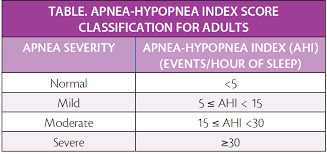

In [12]:
from IPython import display
display.Image("./img.png")

In [13]:
new_df['status']=new_df.AHI.apply(fun)
status=["Severe","Moderate","Mild","Normal"]

In [14]:
new_df.head(10)

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,M,status
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,1,0
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,1,0
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,1,0
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1,0
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1,0
5,0.0,5.0,20.761246,60.0,170.0,56.0,35.0,68.0,90.0,20.0,0.693642,1,0
6,0.0,12.0,22.656114,68.2,173.5,57.0,34.5,76.5,97.0,20.0,1.730769,1,0
7,0.0,0.0,33.910035,98.0,170.0,57.0,39.0,108.0,123.0,20.0,73.861386,1,3
8,0.0,9.0,24.489796,75.0,175.0,58.0,37.0,91.0,100.0,21.0,6.646707,1,0
9,0.0,12.0,25.524316,72.9,169.0,56.5,38.5,88.0,97.5,21.0,2.763158,1,0


In [15]:
final_df = new_df.drop(['AHI'], axis='columns')
final_df.head()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,1,0
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1,0
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,1,0
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0


In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5241 entries, 0 to 5244
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BQ       5241 non-null   float64
 1   ESS      5241 non-null   float64
 2   BMI      5241 non-null   float64
 3   Weight   5241 non-null   float64
 4   Height   5241 non-null   float64
 5   Head     5241 non-null   float64
 6   Neck     5241 non-null   float64
 7   Waist    5241 non-null   float64
 8   Buttock  5241 non-null   float64
 9   Age      5241 non-null   float64
 10  M        5241 non-null   uint8  
 11  status   5241 non-null   int64  
dtypes: float64(10), int64(1), uint8(1)
memory usage: 496.5 KB


0    2903
3    2308
1      17
2      13
Name: status, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

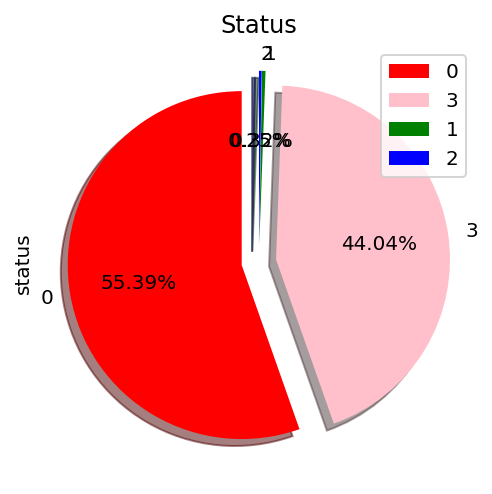

In [17]:
print(final_df.status.value_counts())
color=['r',"pink","green","blue"]
final_df['status'].value_counts().plot.pie(colors=color,startangle=90, shadow=True,explode=(0.1, 0.1, 0.1, 0.1), autopct='%1.2f%%').set_title('Status')
plt.legend()
plt.show

In [18]:
a=(final_df.status.value_counts()[0] / final_df.status.count())*100
a=a.round(3)
print(a)
b=(final_df.status.value_counts()[1] / final_df.status.count())*100
b=b.round(3)
print(b)
c=(final_df.status.value_counts()[2] / final_df.status.count())*100
c=c.round(3)
print(c)
d=(final_df.status.value_counts()[3] / final_df.status.count())*100
d=d.round(3)
print(d)

55.39
0.324
0.248
44.037


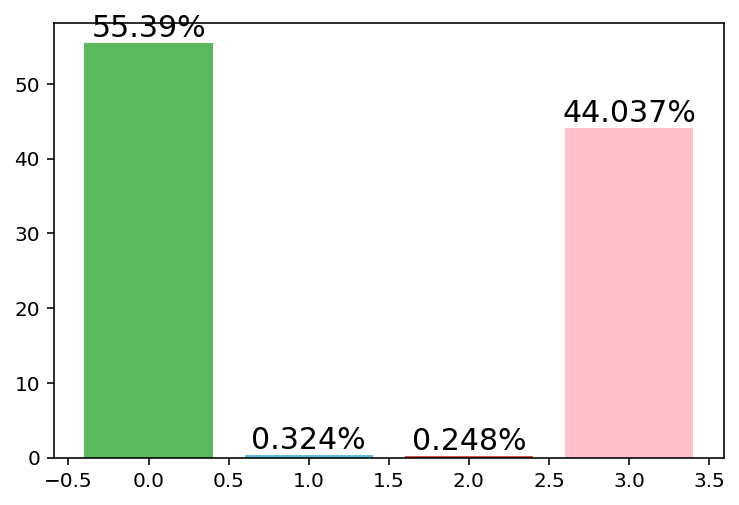

In [19]:
LABELS = ["Normal", "Mild","Moderate","Severe"]
frequencies = (a,b,c,d)

plt.figure()
colors=['#5cb85c','#5bc0de','#d9534f','pink']
p1 = plt.bar(np.arange(len(frequencies)), frequencies,color=colors)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=15)

plt.show()


Text(0, 0.5, 'Frequency')

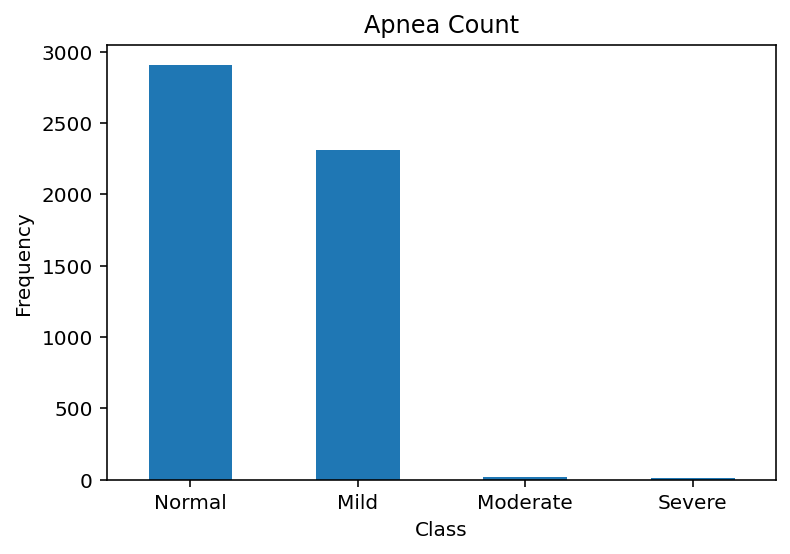

In [20]:
LABELS = ["Normal", "Mild","Moderate","Severe"]

count_classes = pd.value_counts(final_df['status'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Apnea Count")

plt.xticks(range(4), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

#### OUTLIERS DETECTION AND REMOVING

#### IQR TECHNIQUE

In [21]:
final_df.shape

(5241, 12)

In [22]:
#outlier detection using IQR for BQ feature
Q1 = final_df.BQ.quantile(0.05)
Q3 = final_df.BQ.quantile(0.95)
Q1, Q3

(0.0, 1.0)

In [23]:
IQR = Q3 - Q1
IQR

1.0

In [24]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(-1.5, 2.5)

In [25]:
final_df[(final_df.BQ<lower_limit)|(final_df.BQ>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
2545,9.0,0.0,24.622961,72.0,171.0,57.5,35.0,84.5,94.0,50.0,1,0
4626,5.0,2.0,17.146776,45.0,162.0,51.5,28.0,69.5,87.5,46.0,0,0


In [26]:
df_no_outlier = final_df[(final_df.BQ>lower_limit)&(final_df.BQ<upper_limit)]
df_no_outlier.shape

(5239, 12)

In [27]:
Q1 = df_no_outlier.ESS.quantile(0.05)
Q3 = df_no_outlier.ESS.quantile(0.95)
Q1, Q3

(0.0, 20.0)

In [28]:
IQR = Q3 - Q1
IQR

20.0

In [29]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(-30.0, 50.0)

In [30]:
df_no_outlier[(df_no_outlier.ESS<lower_limit)|(df_no_outlier.ESS>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
2049,1.0,999.0,20.242215,58.500000,170.0,55.5,36.5,71.0,89.0,45.0,1,0
3413,1.0,999.0,29.069767,86.000000,172.0,56.5,42.0,104.0,108.0,60.0,1,0
3649,1.0,79.0,24.807473,78.599998,178.0,63.0,42.0,94.0,98.5,64.0,1,0


In [31]:
df_no_outlier = df_no_outlier[(df_no_outlier.ESS>lower_limit) &(df_no_outlier.ESS<upper_limit)]
df_no_outlier.shape

(5236, 12)

In [32]:
Q1 = df_no_outlier.BMI.quantile(0.05)
Q3 = df_no_outlier.BMI.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print(lower_limit, upper_limit)

Q1 VALUE -  19.56823633379624 Q3 VALUE -  36.76590921689596

IQR VALUE 17.197672883099724

-6.228272990853345 62.56241854154555


In [33]:
df_no_outlier[(df_no_outlier.BMI<lower_limit)|(df_no_outlier.BMI>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status


In [34]:
df_no_outlier = df_no_outlier[(df_no_outlier.BMI>lower_limit) &(df_no_outlier.BMI<upper_limit)]
df_no_outlier.shape

(5236, 12)

In [35]:
Q1 = df_no_outlier.Weight.quantile(0.05)
Q3 = df_no_outlier.Weight.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1*IQR
upper_limit = Q3 + 1*IQR
print(lower_limit, upper_limit)

Q1 VALUE -  50.0 Q3 VALUE -  106.0

IQR VALUE 56.0

-6.0 162.0


In [36]:
df_no_outlier[(df_no_outlier.Weight<lower_limit)|(df_no_outlier.Weight>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
152,0.0,7.0,60.232426,170.0,168.0,62.0,49.0,159.0,179.0,25.0,1,3
1200,0.0,10.0,53.737471,178.0,182.0,59.5,48.0,154.0,158.0,37.0,1,3


In [37]:
df_no_outlier = df_no_outlier[(df_no_outlier.Weight>lower_limit) &(df_no_outlier.Weight<upper_limit)]
df_no_outlier.shape

(5234, 12)

In [38]:
Q1 = df_no_outlier.Height.quantile(0.05)
Q3 = df_no_outlier.Height.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1*IQR
upper_limit = Q3 + 1*IQR
print(lower_limit, upper_limit)

Q1 VALUE -  153.0 Q3 VALUE -  180.0

IQR VALUE 27.0

126.0 207.0


In [39]:
df_no_outlier[(df_no_outlier.Height<lower_limit)|(df_no_outlier.Height>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status


In [40]:
df_no_outlier = df_no_outlier[(df_no_outlier.Height>lower_limit) &(df_no_outlier.Height<upper_limit)]
df_no_outlier.shape

(5234, 12)

In [41]:
Q1 = df_no_outlier.Head.quantile(0.05)
Q3 = df_no_outlier.Head.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1*IQR
upper_limit = Q3 + 1*IQR
print(lower_limit, upper_limit)

Q1 VALUE -  53.0 Q3 VALUE -  60.0

IQR VALUE 7.0

46.0 67.0


In [42]:
df_no_outlier[(df_no_outlier.Head<lower_limit)|(df_no_outlier.Head>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
29,0.0,18.0,25.180785,78.0,176.0,36.5,37.0,88.5,102.0,22.0,1,0
201,0.0,0.0,21.967120,62.0,168.0,42.8,33.5,78.0,92.5,26.0,1,0
291,0.0,14.0,22.340297,74.0,182.0,45.0,34.2,80.5,96.5,28.0,1,0
490,0.0,14.0,25.593737,68.0,163.0,45.0,36.5,87.5,94.0,31.0,1,0
565,0.0,16.0,40.745465,115.0,168.0,68.0,52.0,124.0,126.0,31.0,1,3
1425,1.0,10.0,25.142857,77.0,175.0,45.5,38.5,89.0,103.5,39.0,1,0
1446,0.0,16.0,20.478267,62.0,174.0,37.5,35.0,80.0,89.0,39.0,1,3
2028,0.0,3.0,26.827421,85.0,178.0,69.5,39.0,92.0,103.5,45.0,1,0
2809,1.0,11.0,29.745809,88.0,172.0,43.5,60.0,107.0,101.5,52.0,1,3
2931,0.0,7.0,24.977043,68.0,165.0,37.0,36.8,88.5,94.0,54.0,1,0


In [43]:
df_no_outlier = df_no_outlier[(df_no_outlier.Head>lower_limit) &(df_no_outlier.Head<upper_limit)]
df_no_outlier.shape

(5213, 12)

In [44]:
Q1 = df_no_outlier.Neck.quantile(0.05)
Q3 = df_no_outlier.Neck.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1*IQR
upper_limit = Q3 + 1*IQR
print(lower_limit, upper_limit)
df_no_outlier[(df_no_outlier.Neck<lower_limit)|(df_no_outlier.Neck>upper_limit)]

Q1 VALUE -  30.5 Q3 VALUE -  45.0

IQR VALUE 14.5

16.0 59.5


,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status


In [45]:
df_no_outlier = df_no_outlier[(df_no_outlier.Neck>lower_limit) &(df_no_outlier.Neck<upper_limit)]
df_no_outlier.shape

(5213, 12)

In [46]:
Q1 = df_no_outlier.Waist.quantile(0.05)
Q3 = df_no_outlier.Waist.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1*IQR
upper_limit = Q3 + 1*IQR
print(lower_limit, upper_limit)

Q1 VALUE -  69.0 Q3 VALUE -  116.0

IQR VALUE 47.0

22.0 163.0


In [47]:
df_no_outlier[(df_no_outlier.Waist<lower_limit)|(df_no_outlier.Waist>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
384,0.0,5.0,45.131715,139.8,176.0,57.0,45.0,182.0,106.0,29.0,1,0


In [48]:
df_no_outlier = df_no_outlier[(df_no_outlier.Waist>lower_limit) &(df_no_outlier.Waist<upper_limit)]
df_no_outlier.shape

(5212, 12)

In [49]:
Q1 = df_no_outlier.Buttock.quantile(0.05)
Q3 = df_no_outlier.Buttock.quantile(0.95)
print("Q1 VALUE - ",Q1, "Q3 VALUE - ",  Q3)
IQR = Q3 - Q1
print()
print("IQR VALUE",IQR)
print()
lower_limit = Q1 - 1*IQR
upper_limit = Q3 + 1*IQR
print(lower_limit, upper_limit)
df_no_outlier[(df_no_outlier.Buttock<lower_limit)|(df_no_outlier.Buttock>upper_limit)]

Q1 VALUE -  88.0 Q3 VALUE -  119.0

IQR VALUE 31.0

57.0 150.0


,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
919,0.0,16.0,60.204237,158.0,162.0,58.5,48.0,160.0,155.0,34.0,1,3
920,0.0,16.0,60.204237,158.0,162.0,58.5,48.0,160.0,155.0,34.0,1,3


In [50]:
df_no_outlier = df_no_outlier[(df_no_outlier.Buttock>lower_limit) &(df_no_outlier.Buttock<upper_limit)]
df_no_outlier.shape

(5208, 12)

In [51]:
df1=df_no_outlier 
print(df1.head())
print(df1.shape)

    BQ   ESS        BMI  Weight  Height  Head  Neck  Waist  Buttock   Age  M  \
0  0.0  14.0  29.065927    88.0   174.0  57.5  39.0   95.5    106.5  20.0  1   
1  0.0   8.0  26.989619    78.0   170.0  57.0  36.5   90.0    100.0  20.0  1   
2  0.0  16.0  23.939481    75.0   177.0  59.0  39.0   88.0    104.0  20.0  1   
3  0.0  15.0  22.129740    67.0   174.0  57.0  35.0   74.0     94.0  20.0  1   
4  0.0  15.0  22.129740    67.0   174.0  57.0  35.0   74.0     94.0  20.0  1   

   status  
0       0  
1       0  
2       0  
3       0  
4       0  
(5208, 12)


<AxesSubplot:>

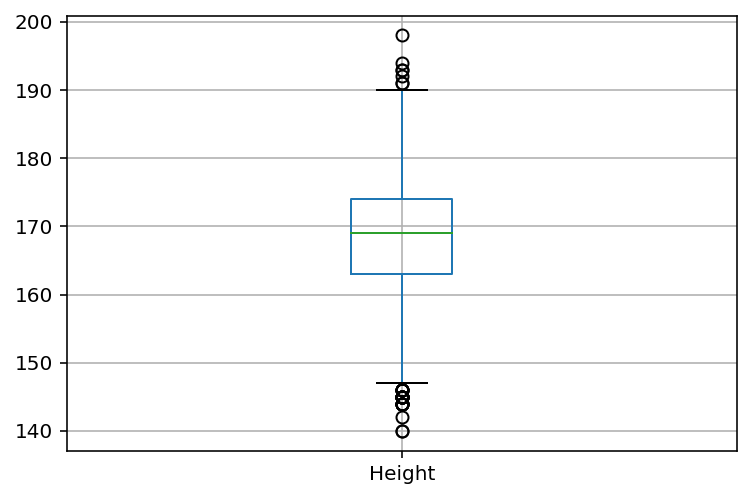

In [55]:
df1.boxplot(column="Height")

In [52]:
X = df1.drop('status', axis=1)   # axis=0 for row, axis=1 for column
y = df1['status']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (4166, 11)
y_train (4166,)
X_test (1042, 11)
y_test (1042,)


# K48,c45,j4.8


In [142]:
def evaluate(model, X_test , y_test,modelname):
  y_pred1=model.predict(X_test)
  #precision    = precision_score(y_test, y_pred1)
 # recall       = recall_score(y_test, y_pred1)
 # f1score      = f1_score(y_test, y_pred1) 
 # rocauc       = roc_auc_score(y_test, y_pred1)
  #logloss      = log_loss(y_test, y_pred1)
  accuracy     = accuracy_score(y_test, y_pred1)
  confusion    = confusion_matrix(y_test, y_pred1)
  df_model1 = pd.DataFrame({  'model'        : [modelname],
                             'accuracy'     : [accuracy],
                             #'precision'    : [precision],
                             #'recall'       : [recall],
                             #'f1score'      : [f1score],
                             #'rocauc'       : [rocauc],
                            # 'logloss'      : [logloss],
                             'timetaken'    : [time2],
                            'confusionmatrix' : [confusion]
                            
                                }) 
  return df_model1

In [143]:
from sklearn import linear_model,svm, tree
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
model1= linear_model.LinearRegression(fit_intercept=True)
svr_poly = svm.SVR(kernel='linear', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)
dtree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.13, random_state=3)
sv=svm.SVC(C=10,kernel='linear')

In [144]:
%%time
time2=time.time()
print("base model")
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
#base_accuracy = evaluate(base_model, X_test, y_test,modelname)
model1 = evaluate(base_model,  X_test,  y_test, 'RandomForest')
model1.timetaken[0] = time.time() - time2
print("Random Forest")
print(base_model.get_params())

model1

base model
Random Forest
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 1.23 s


,model,accuracy,timetaken,confusionmatrix
0,RandomForest,0.792706,1.234584,"[[481, 0, 0, 86], [4, 1, 0, 0], [1, 0, 0, 0], ..."


In [145]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

time2=time.time()
print("base model")
base_model1 = ExtraTreesClassifier()
base_model1.fit(X_train, y_train)
model2 = evaluate(base_model1,  X_test,  y_test, 'Extra Tree')
model2.timetaken[0] = time.time() - time2
print("Extra Tree")
print(base_model1.get_params())

base model
Extra Tree
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 873 ms


In [146]:
%%time
time2=time.time()
print("base model")
base_model2 = LogisticRegression()
base_model2.fit(X_train, y_train)
model3 = evaluate(base_model2,  X_test,  y_test, 'Logistic Regression')
model3.timetaken[0] = time.time() - time2
print("Logoistic Regression")
print(base_model2.get_params())

base model
Logoistic Regression
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Wall time: 311 ms


In [147]:
%%time
time2=time.time()
print("base model")
base_model3 = KNeighborsClassifier()
base_model3.fit(X_train, y_train)
model4 = evaluate(base_model3,  X_test,  y_test, 'KNN')
model4.timetaken[0] = time.time() - time2
print("KNN")
print(base_model3.get_params())

base model
KNN
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Wall time: 88.4 ms


In [148]:
%%time
time2=time.time()
print("base model")
base_model4 = LinearSVC()
base_model4.fit(X_train, y_train)
model5 = evaluate(base_model4,  X_test,  y_test, 'LinearSVC')
model5.timetaken[0] = time.time() - time2
print("LinearSVC")
print(base_model4.get_params())

base model
LinearSVC
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Wall time: 1.29 s


In [149]:
%%time
time2=time.time()
print("base model")
base_model5 = GaussianNB()
base_model5.fit(X_train, y_train)
model6 = evaluate(base_model5,  X_test,  y_test, 'GaussianNB')
model6.timetaken[0] = time.time() - time2
print("GaussianNB")
print(base_model5.get_params())

base model
GaussianNB
{'priors': None, 'var_smoothing': 1e-09}
Wall time: 20.6 ms


In [150]:
%%time
time2=time.time()
print("base model")
base_model6=SVC()
base_model6.fit(X_train, y_train)
model7 = evaluate(base_model6,  X_test,  y_test, 'SVC')
model7.timetaken[0] = time.time() - time2
print("SVC")
print(base_model6.get_params())

base model
SVC
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Wall time: 1.47 s


In [151]:
%%time
time2=time.time()
print("base model")
base_model7=DecisionTreeClassifier()
base_model7.fit(X_train, y_train)
model8 = evaluate(base_model7,  X_test,  y_test, 'Decision Tree')
model8.timetaken[0] = time.time() - time2
print("Decision Tree")
print(base_model7.get_params())

base model
Decision Tree
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Wall time: 50.9 ms


In [152]:
df_base= pd.concat([model1,model2,model3,model4,model5,model6,model7,model8],axis = 0).reset_index()
df_base.drop('index', axis=1, inplace=True)
df_base

,model,accuracy,timetaken,confusionmatrix
0,RandomForest,0.792706,1.234584,"[[481, 0, 0, 86], [4, 1, 0, 0], [1, 0, 0, 0], ..."
1,Extra Tree,0.797505,0.872955,"[[482, 0, 0, 85], [4, 1, 0, 0], [1, 0, 0, 0], ..."
2,Logistic Regression,0.774472,0.311088,"[[467, 0, 0, 100], [5, 0, 0, 0], [1, 0, 0, 0],..."
3,KNN,0.756238,0.088416,"[[454, 0, 0, 113], [5, 0, 0, 0], [1, 0, 0, 0],..."
4,LinearSVC,0.657390,1.289053,"[[556, 0, 0, 11], [5, 0, 0, 0], [1, 0, 0, 0], ..."
5,GaussianNB,0.743762,0.012572,"[[449, 0, 0, 118], [5, 0, 0, 0], [1, 0, 0, 0],..."
6,SVC,0.769674,1.470526,"[[463, 0, 0, 104], [5, 0, 0, 0], [1, 0, 0, 0],..."
7,Decision Tree,0.730326,0.050941,"[[422, 2, 4, 139], [4, 1, 0, 0], [1, 0, 0, 0],..."


In [67]:
#df_base['confusionmatrix']
#df_base.to_csv('D:\MAJOR PROJECT\confusionmatrix.csv')

In [68]:
# libraries 
!pip install yellowbrick
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [69]:
X = df1.drop('status', axis=1)   # axis=0 for row, axis=1 for column
y = df1['status']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (4166, 11)
y_train (4166,)
X_test (1042, 11)
y_test (1042,)


In [70]:
classes = y.value_counts().index.tolist()
classes

[0, 3, 1, 2]

In [71]:
classifiers=[
DecisionTreeClassifier(),
SVC(),
GaussianNB(),
KNeighborsClassifier(),
LogisticRegression(),
RandomForestClassifier()]

In [72]:
#Write function for class-centric metrics
# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        Class_report(name,classes)

#Class Prediction Error
def CPE_viz():    
    def CPE(model,classes):
        visualizer = ClassPredictionError(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CPE(name,classes)
        
#Confusion matrix
def CM_viz():    
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes,percent=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CM(name,classes)
        
#ROC-AUC
def ROC_viz():    
    def ROC(model,classes):
        visualizer = ROCAUC(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        ROC(name,classes)

#Precision Recall Curve
def PRC_viz():  
    def PRC(model,classes):
        visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
    fill_area=False, micro=False)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        PRC(name,classes)


In [73]:
# Write function for aggregate metrics
def classifier_metrics():    
    def metrics(model):
        #     model=model_name()
        model.fit(X_train, y_train)  # Fit the visualizer and the model
        y_pred = model.predict(X_test)
        try: 
            y_prob = model.predict_proba(X_test)
            log_metric = log_loss(y_test,y_prob)
        except:
            y_prob = "Not probablistic"
            log_metric = 0
        else:
            y_pred = model.predict(X_test)
        c_k_s=cohen_kappa_score(y_test,y_pred)
        zero_met=zero_one_loss(y_test,y_pred)
        hl=hamming_loss(y_test,y_pred)
        mc=matthews_corrcoef(y_test,y_pred)
        print('cohen_kappa_score: {0:.3f}'.format(c_k_s))
        print('log_loss: {0:.3f}'.format(log_metric))
        print('zero_one_loss: {0:.3f}'.format(zero_met))
        print('hemming_loss: {0:.3f}'.format(hl))
        print('matthews_corrcoef: {0:.3f}'.format(mc))
    for name in classifiers:
        print (str(name))
        metrics(name)
        print()
        print ("------------------------------------------------------")

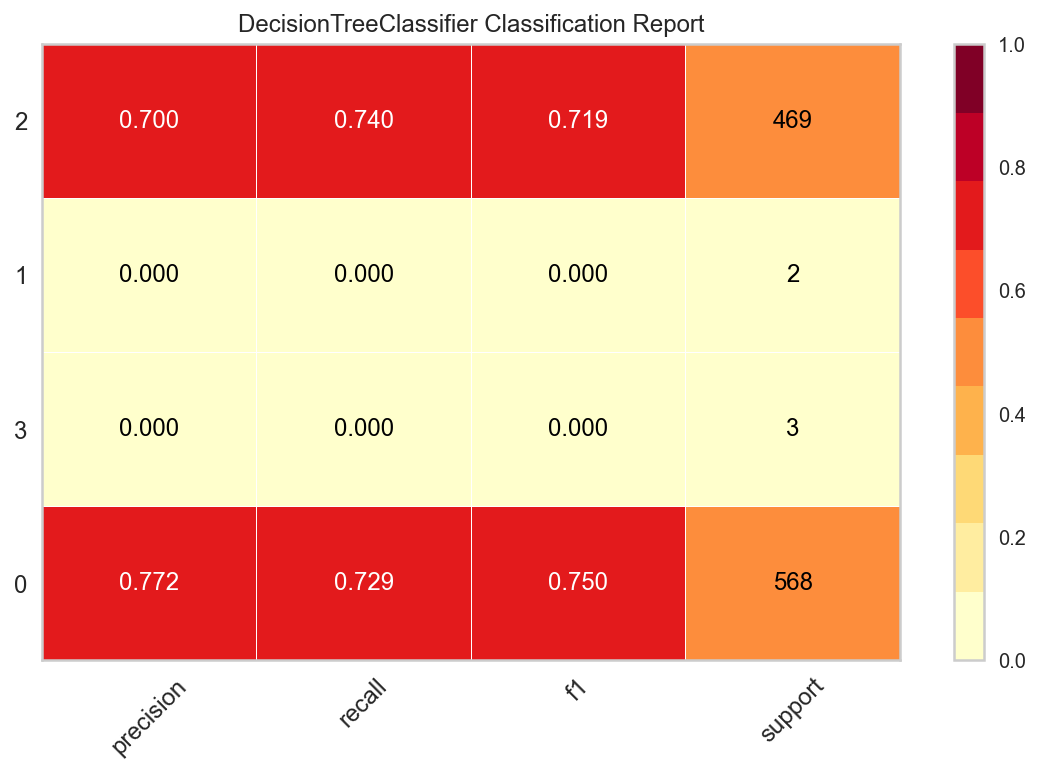

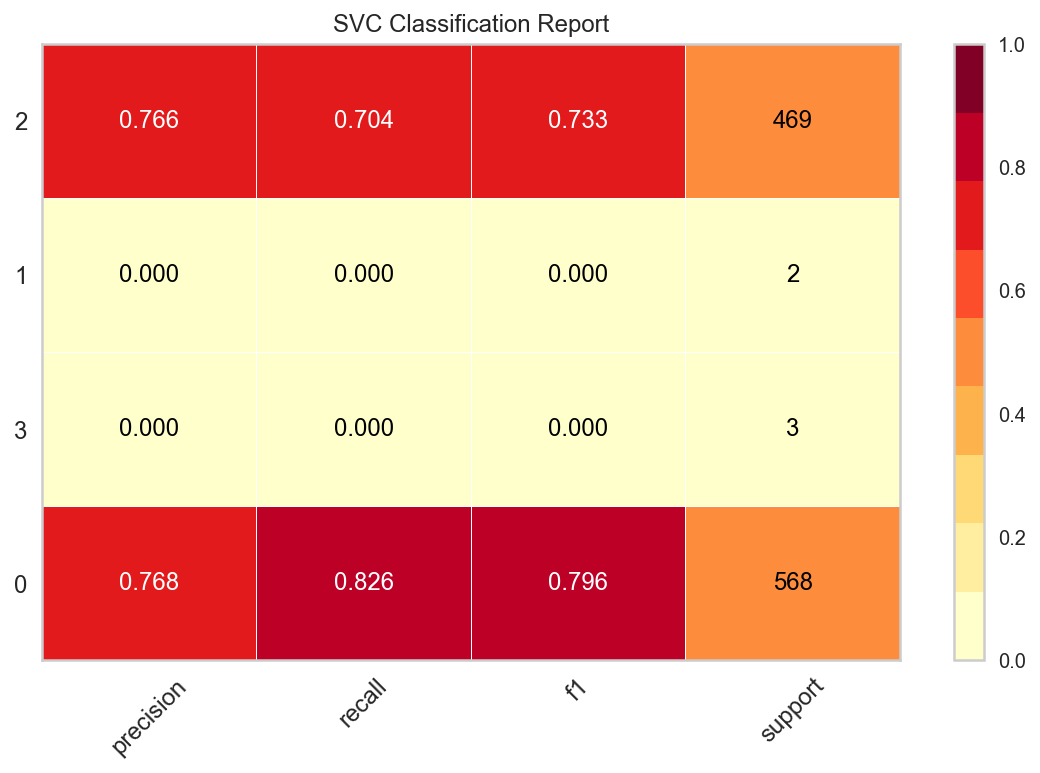

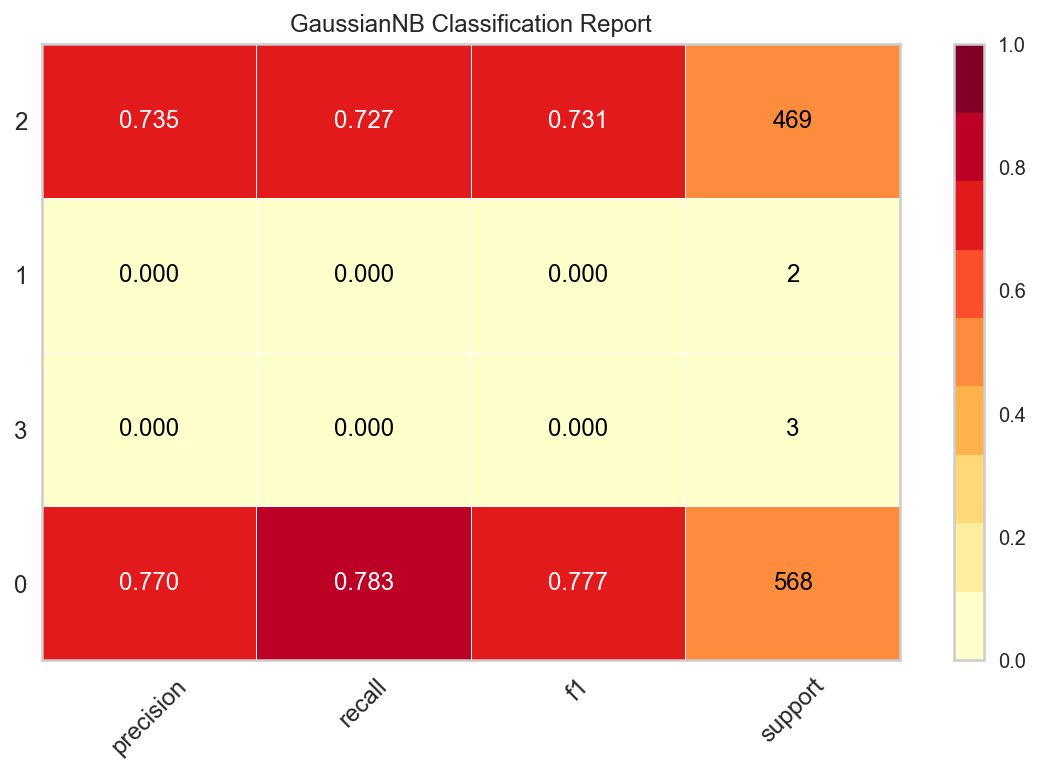

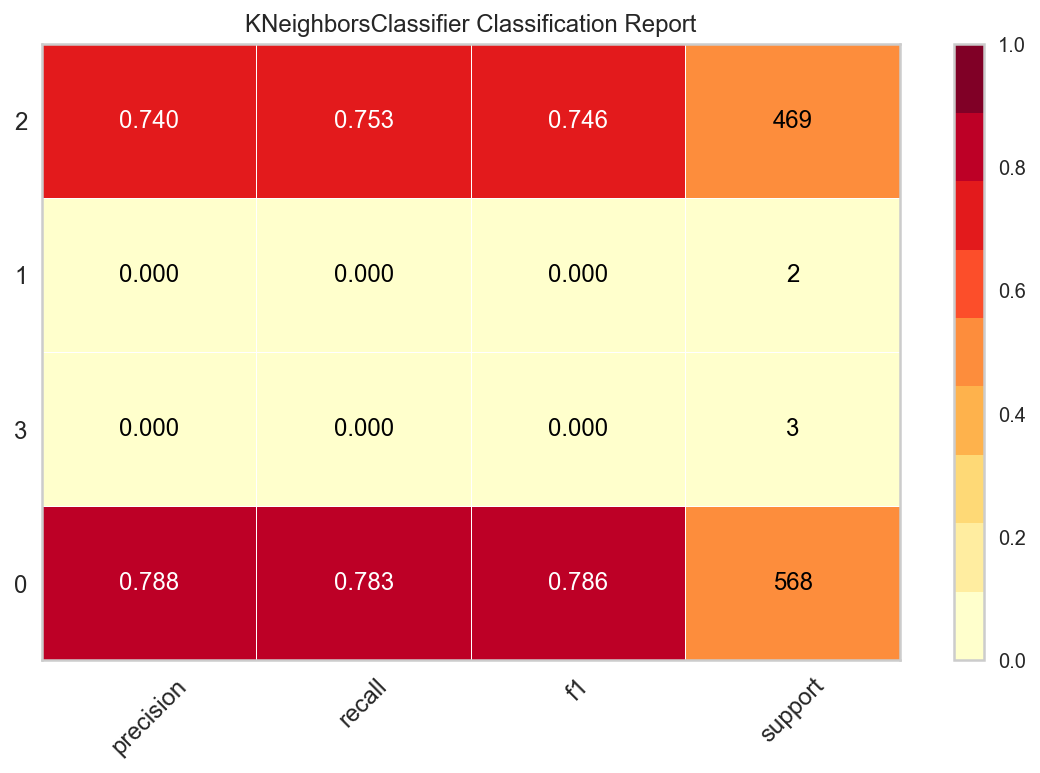

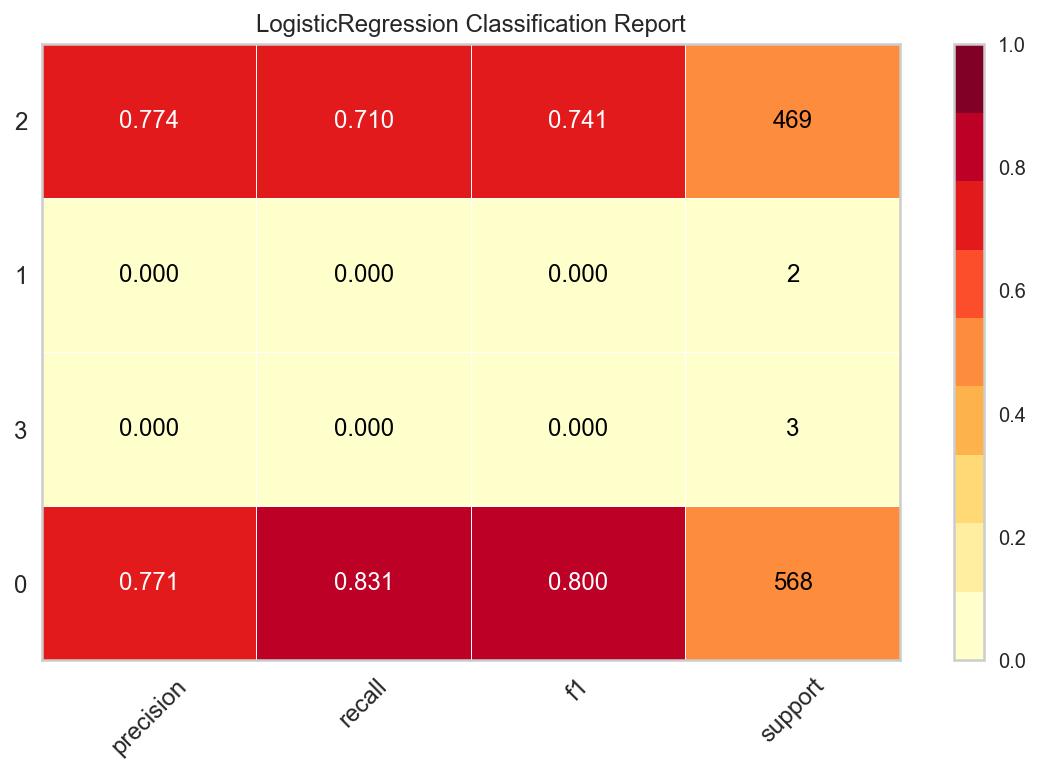

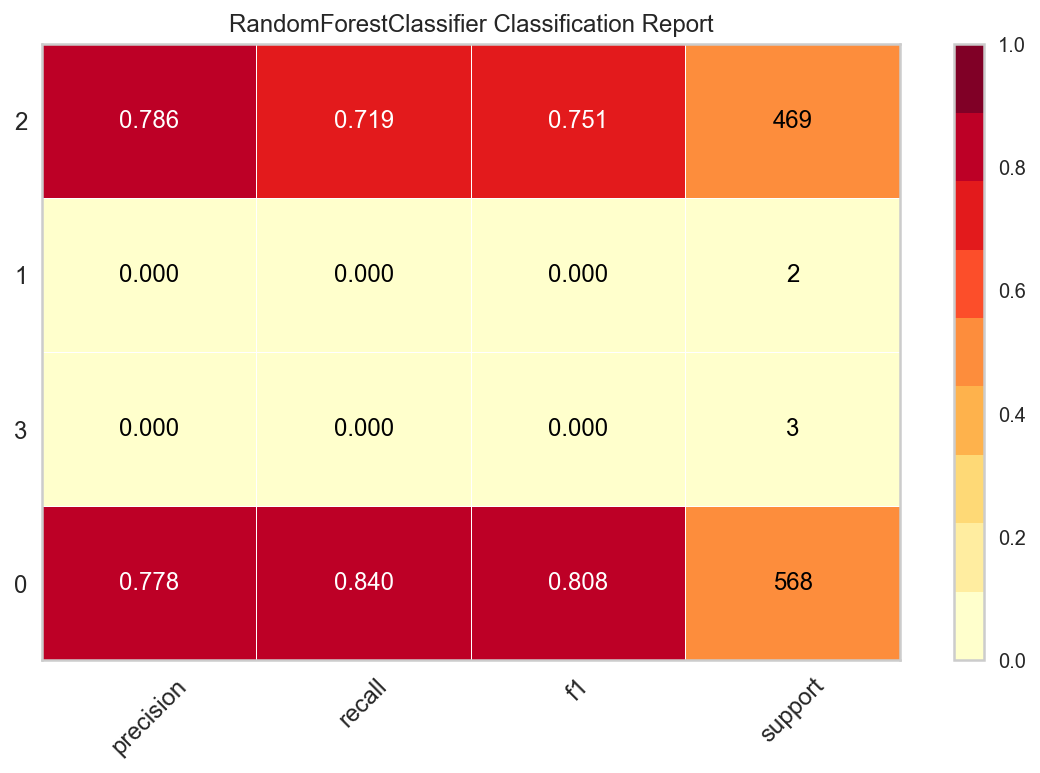

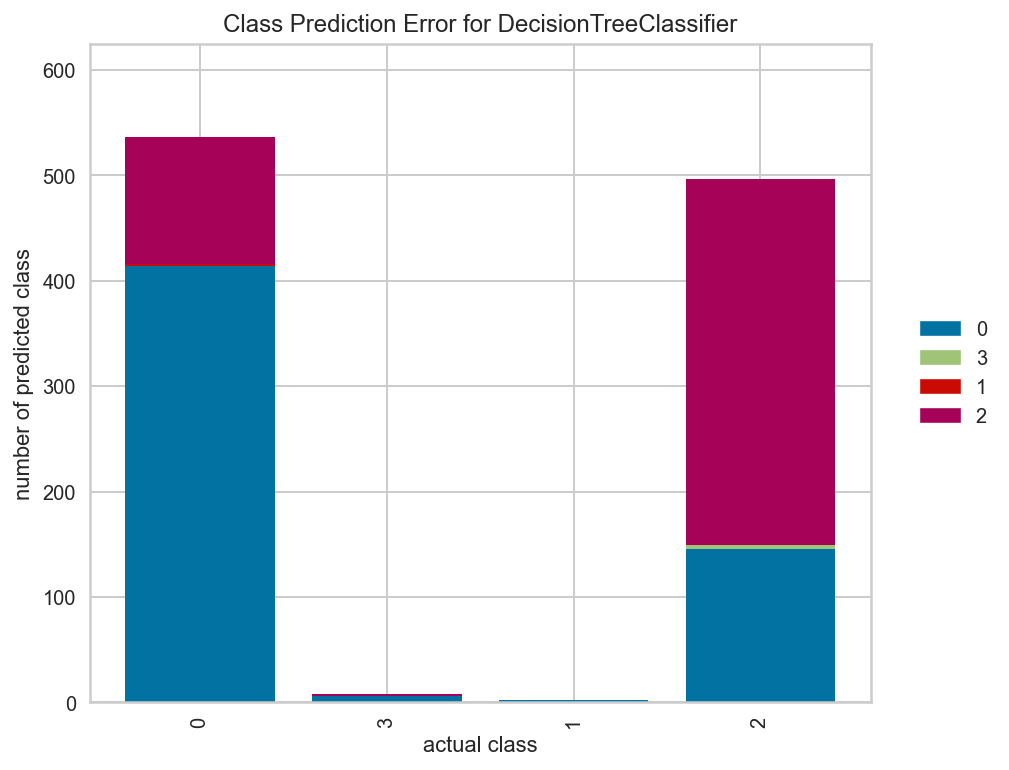

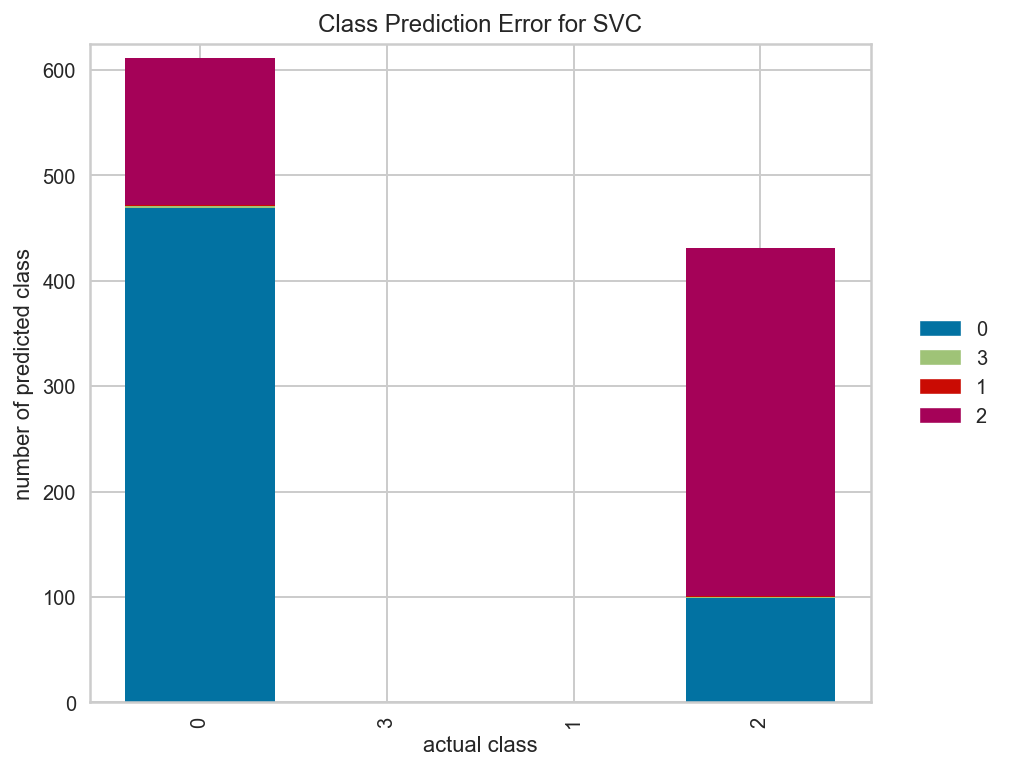

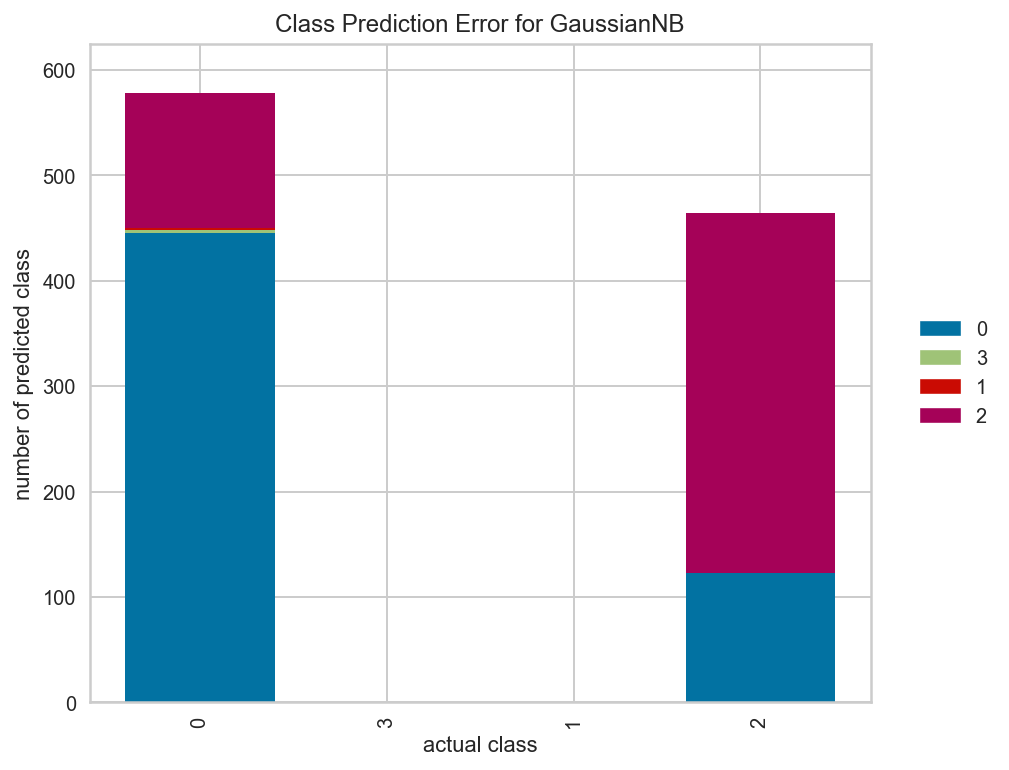

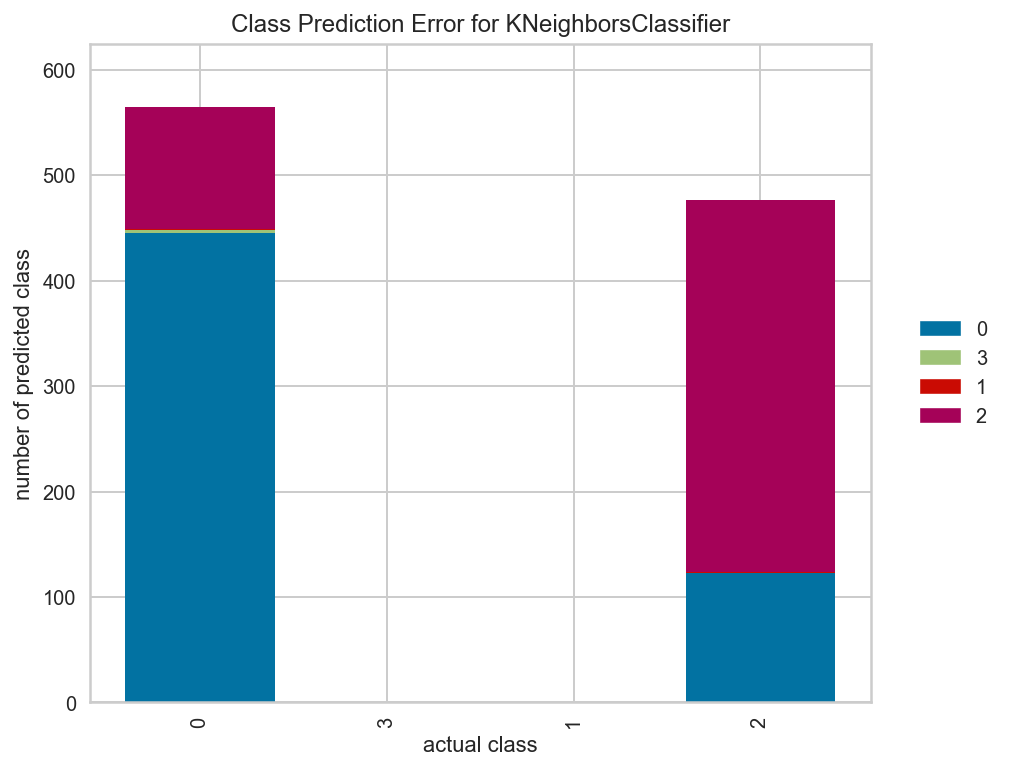

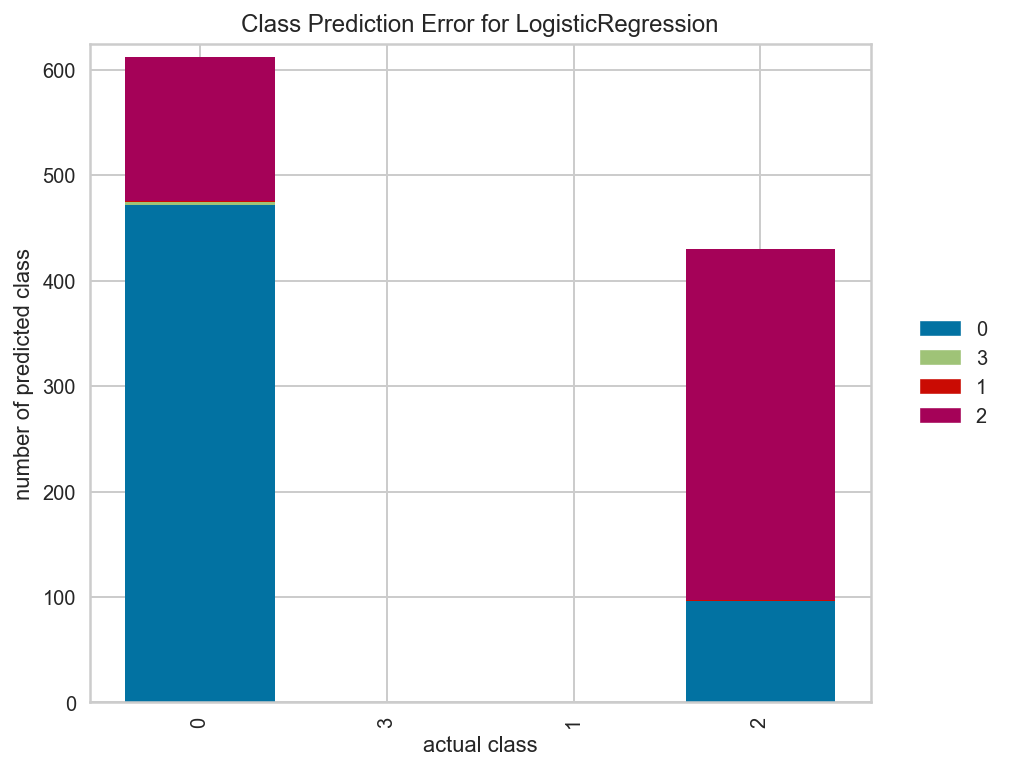

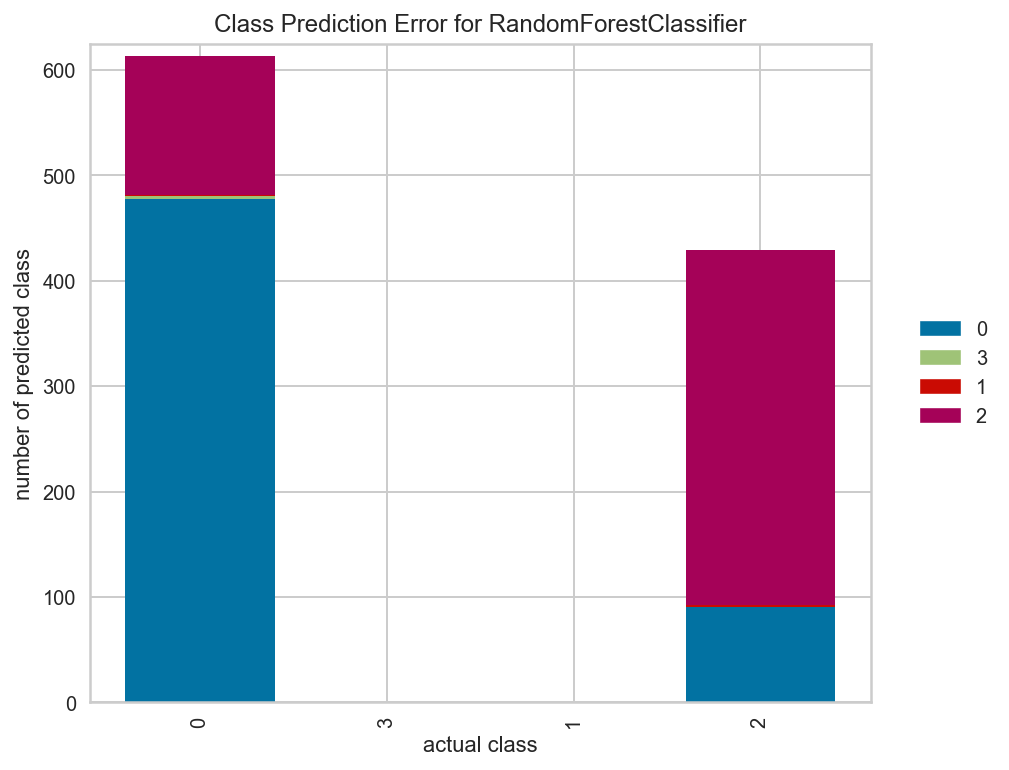

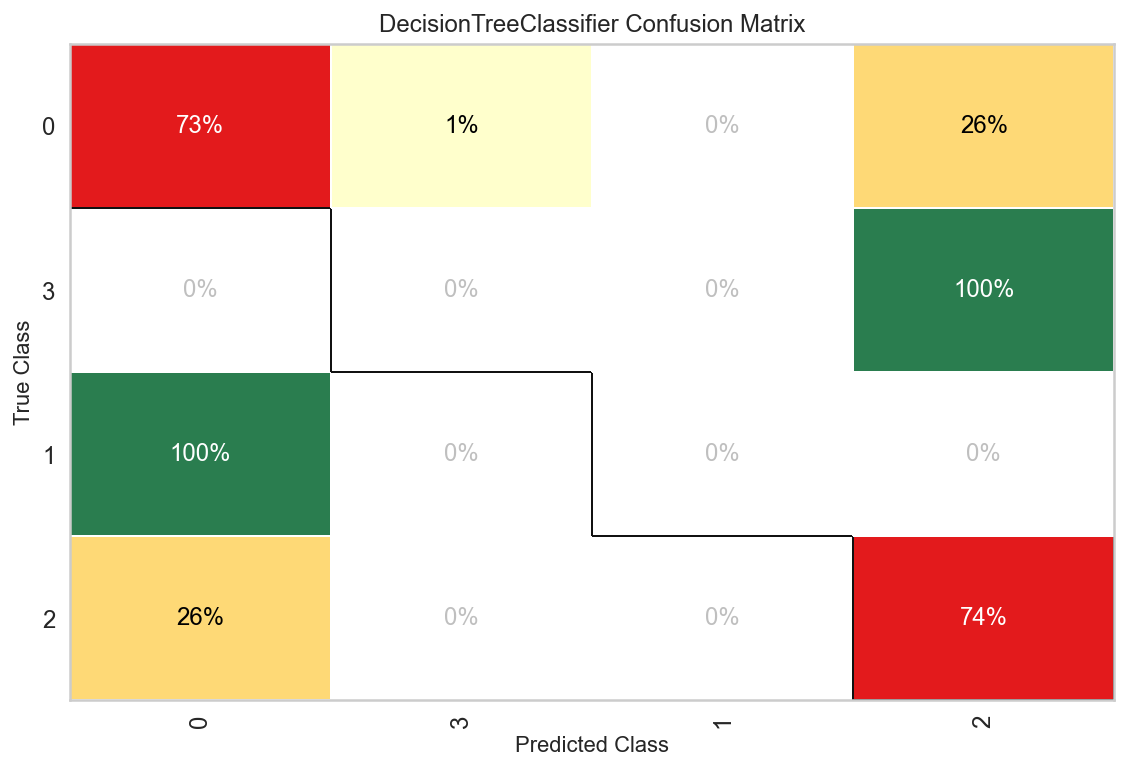

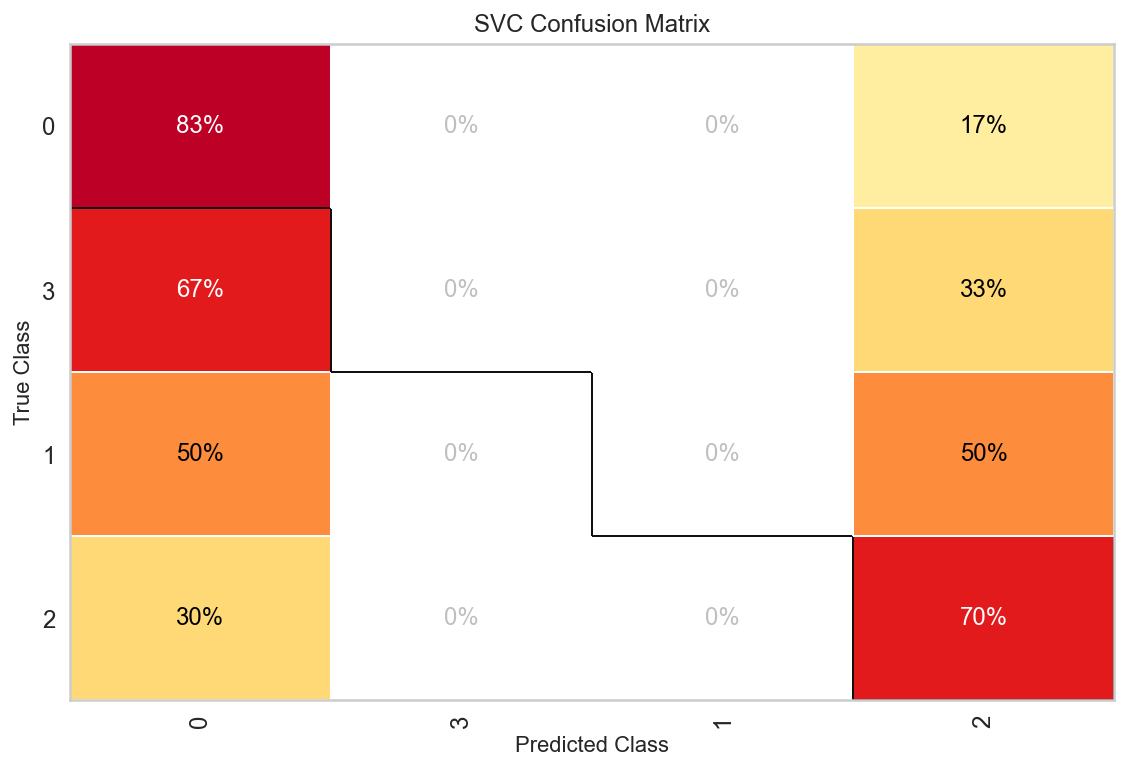

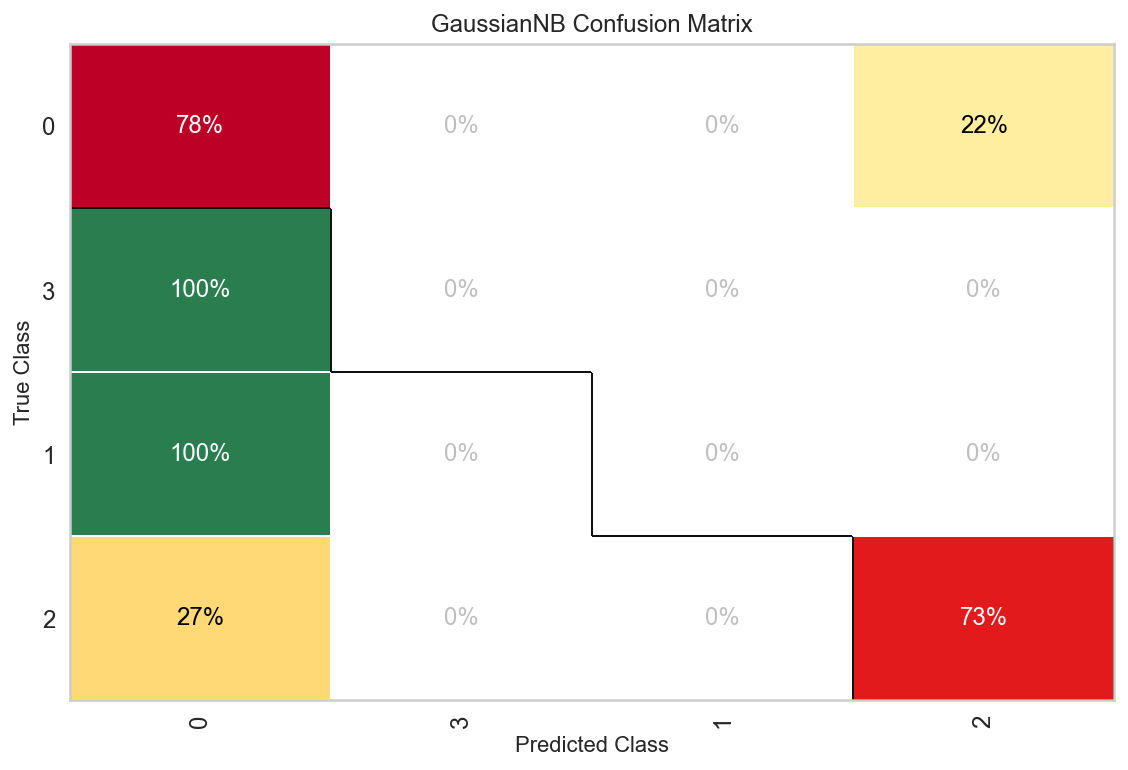

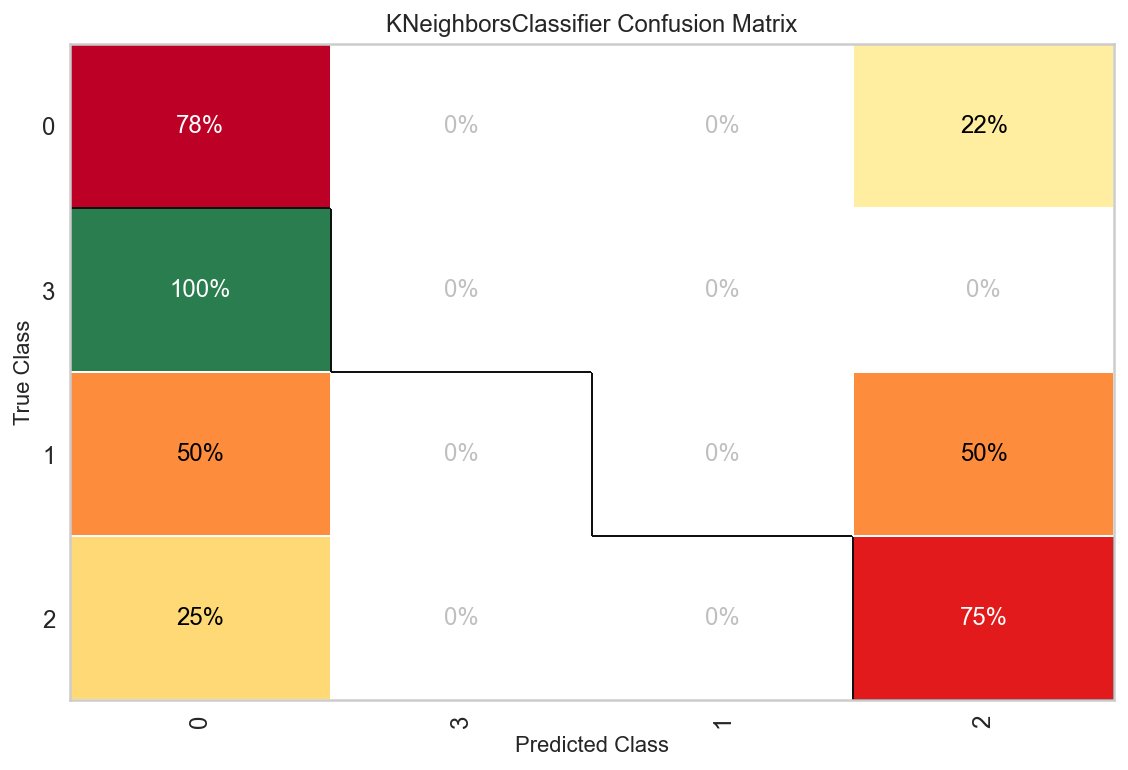

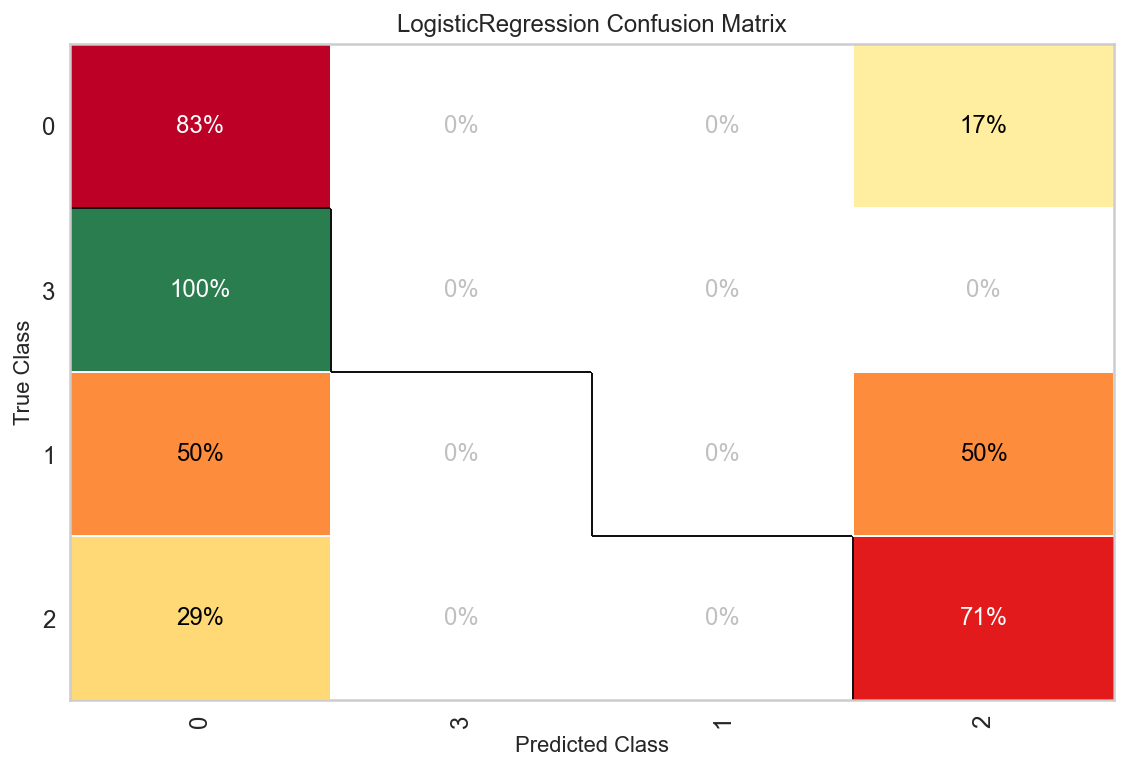

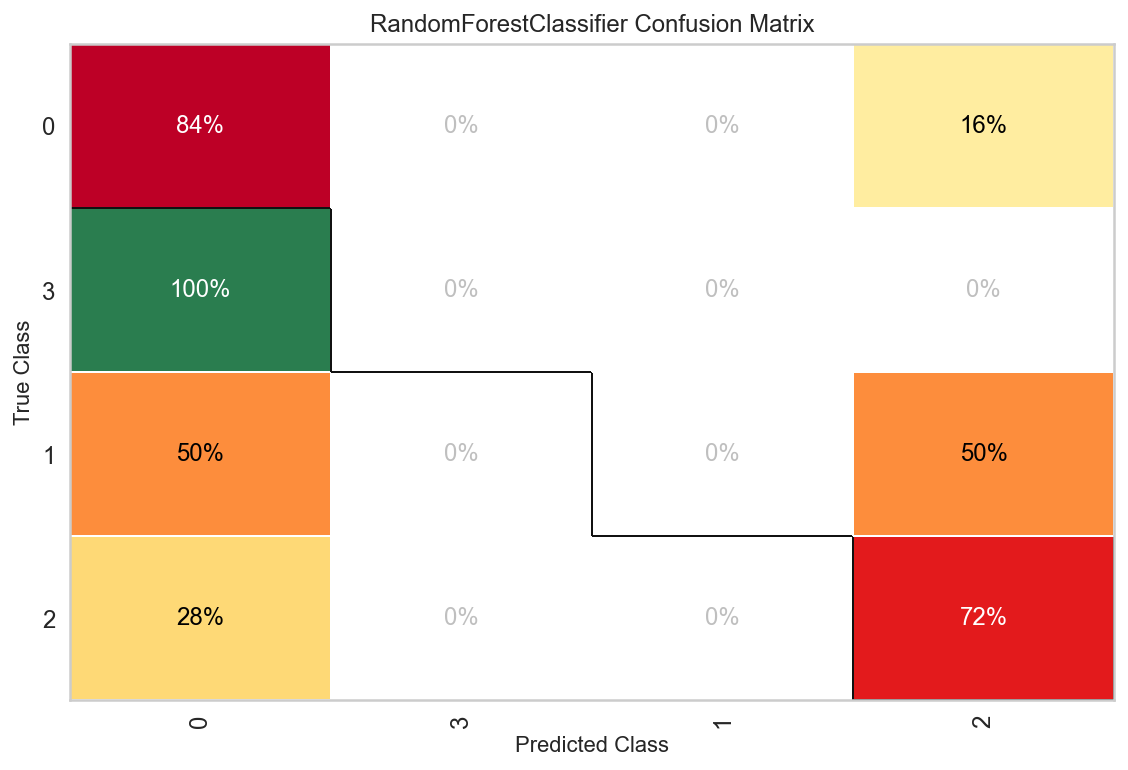

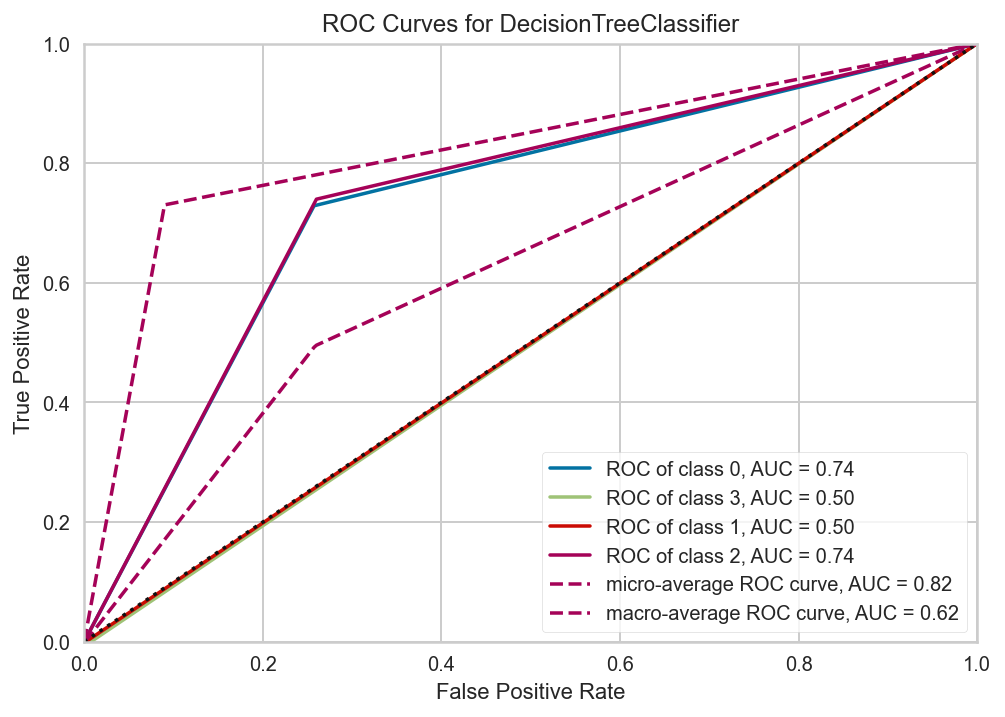

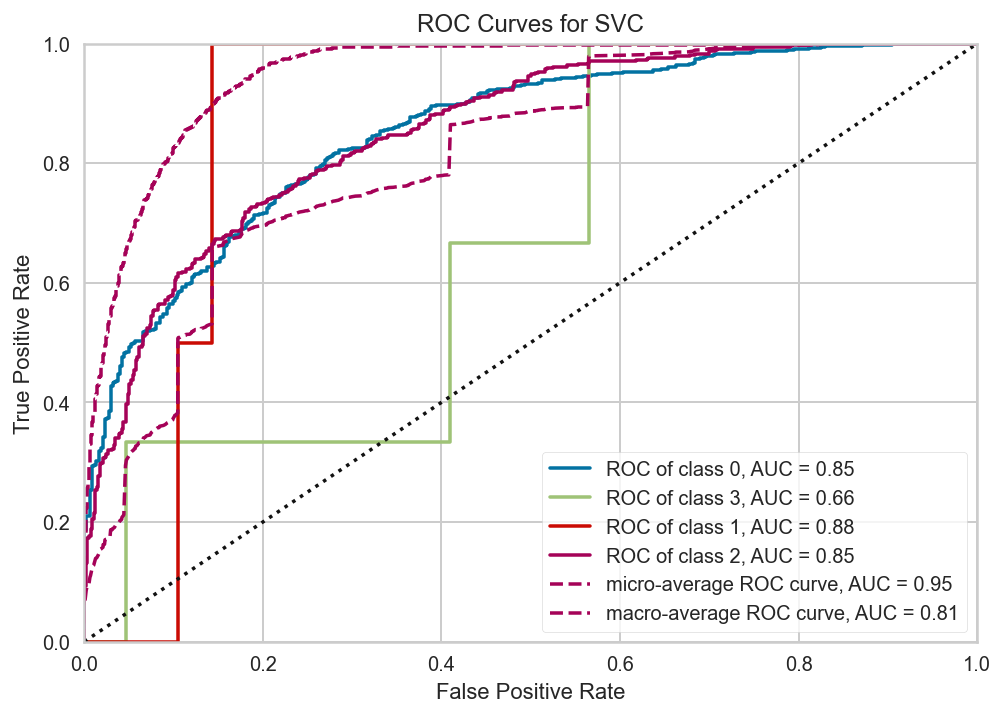

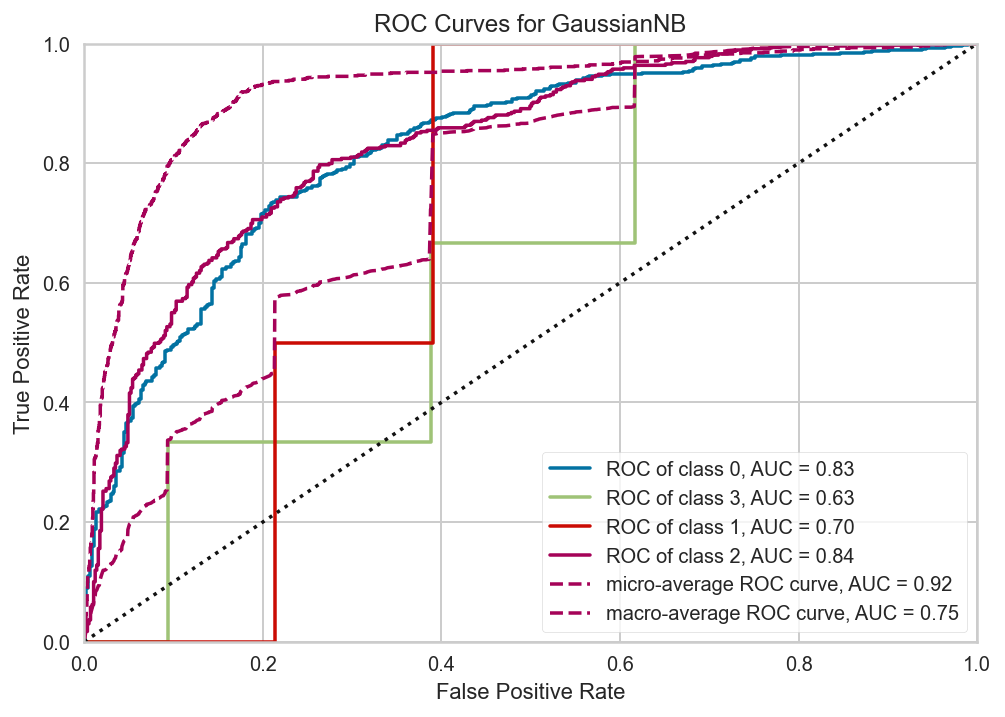

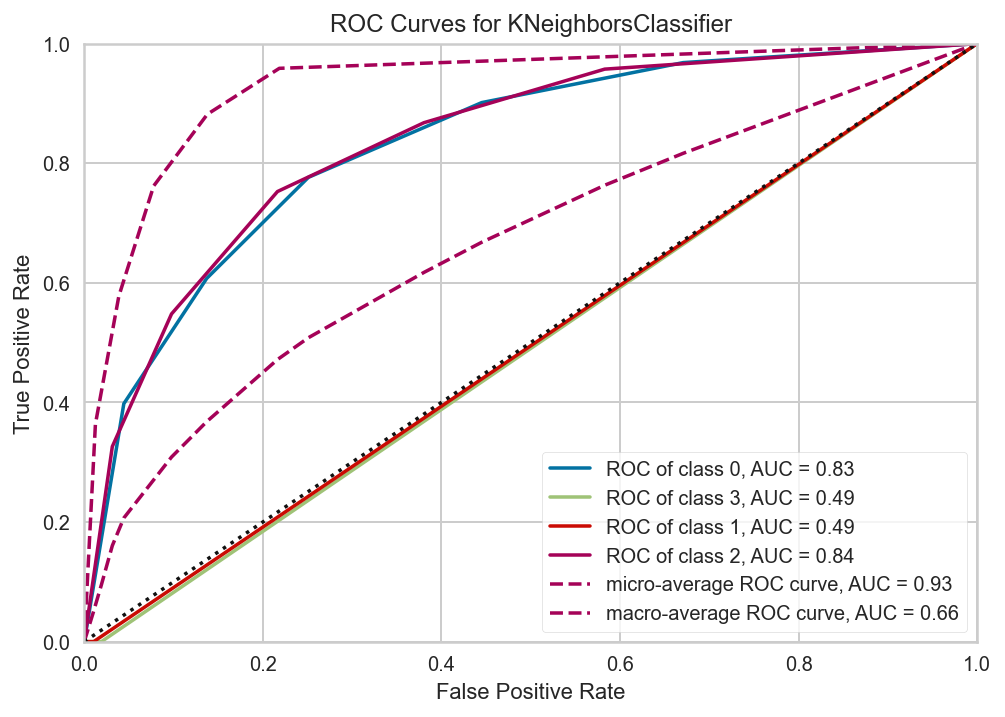

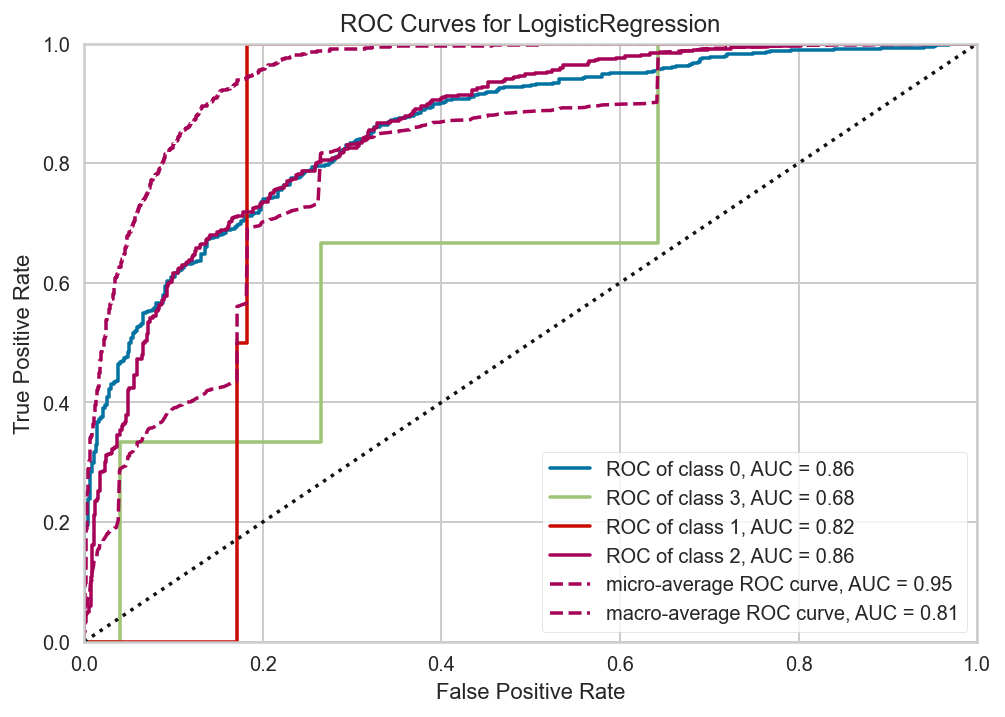

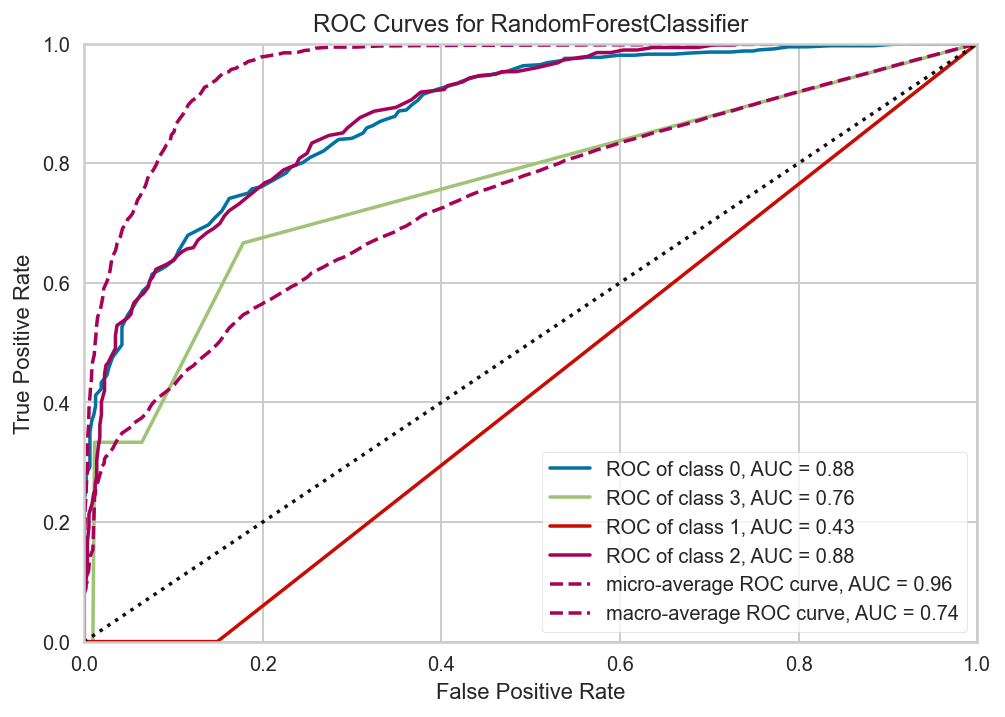

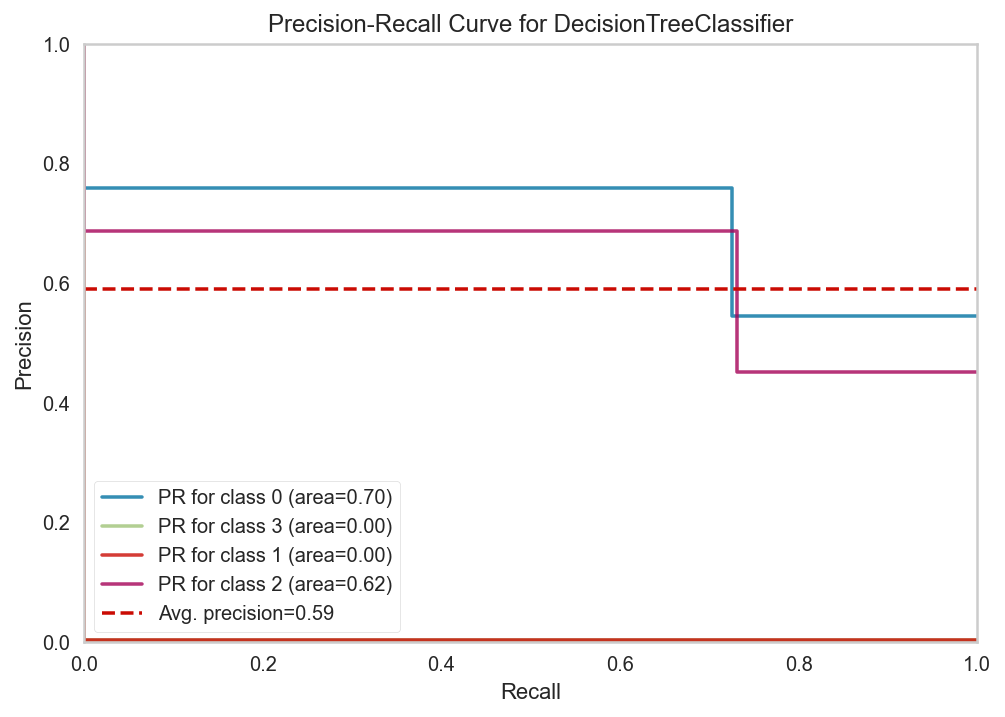

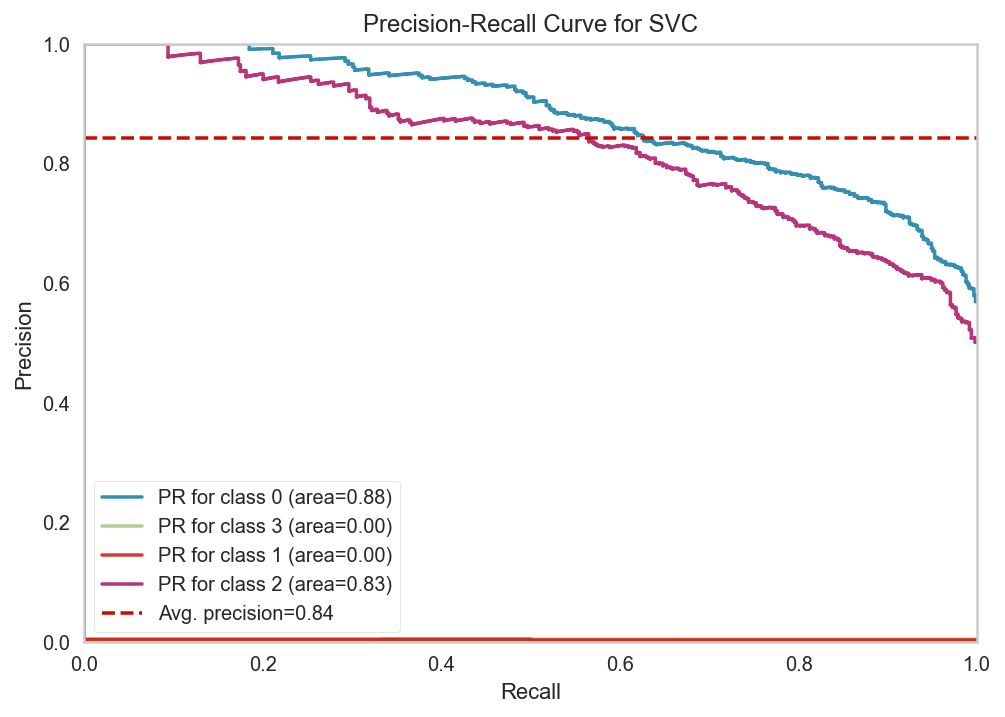

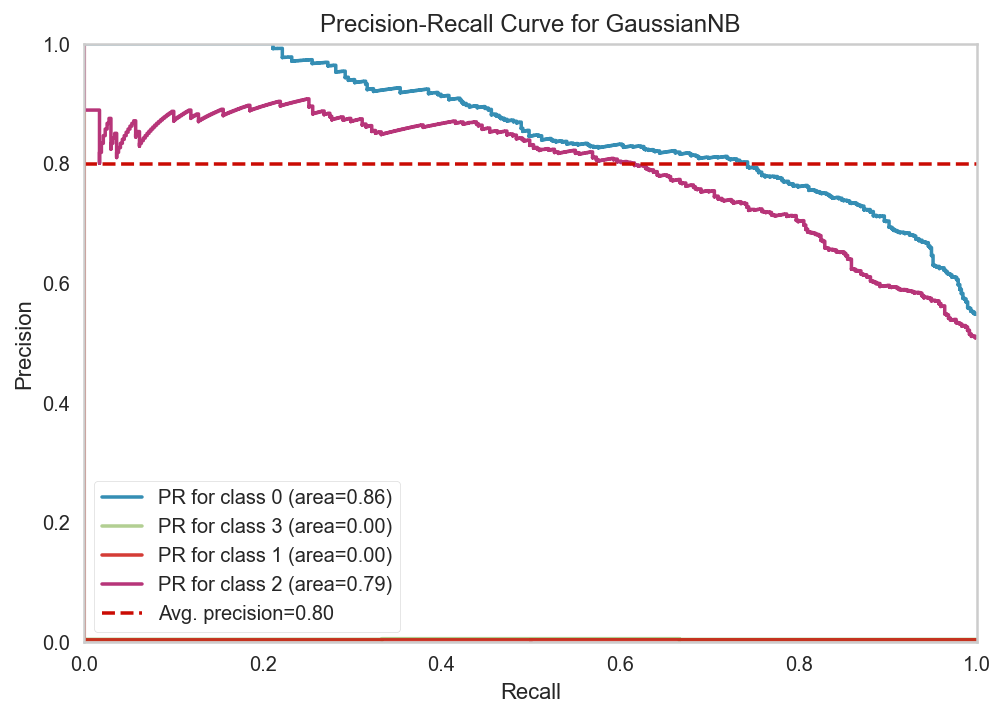

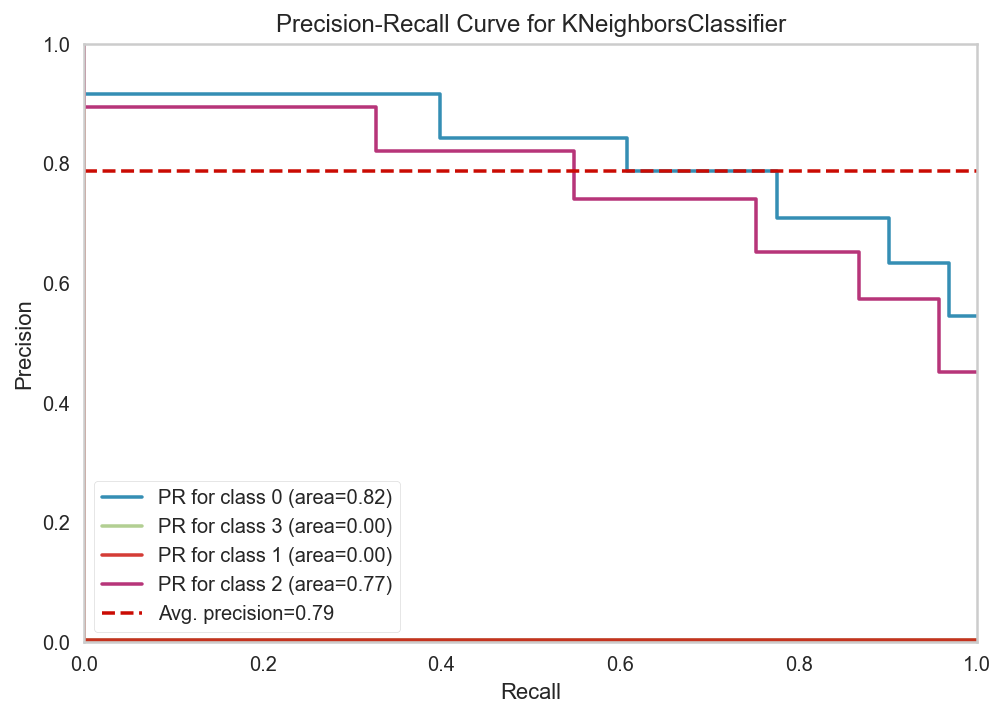

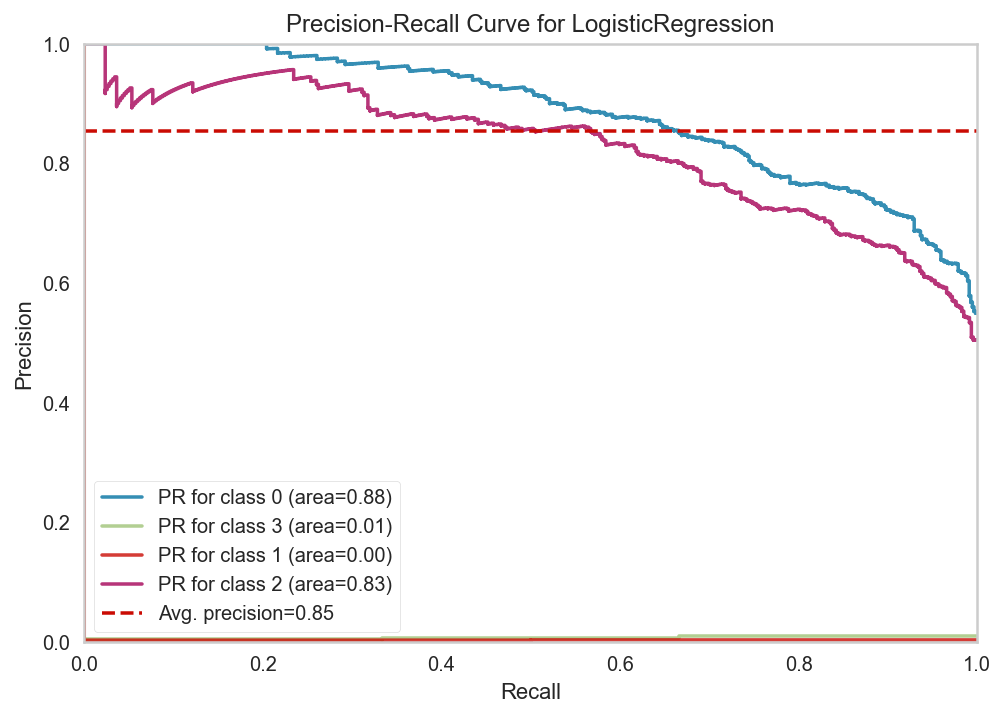

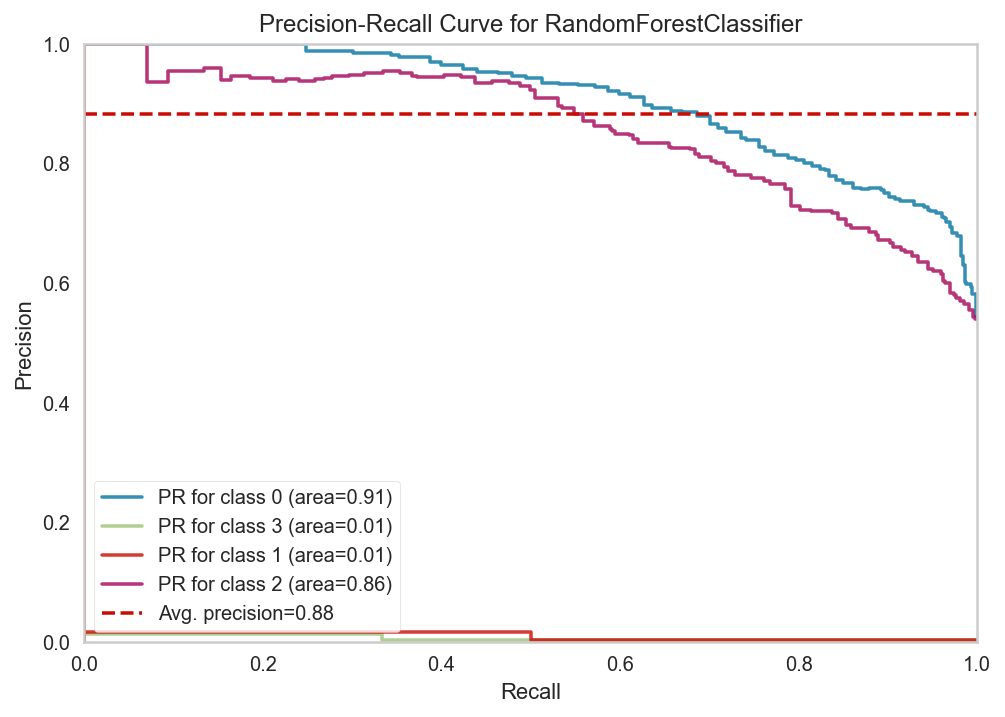

In [74]:
#deploy visualization
visualization =[CR_viz(),CPE_viz(),CM_viz(),ROC_viz(),PRC_viz()]

In [75]:
#Deploy aggregate metrics  
classifier_metrics()

DecisionTreeClassifier()
cohen_kappa_score: 0.477
log_loss: 9.115
zero_one_loss: 0.264
hemming_loss: 0.264
matthews_corrcoef: 0.477

------------------------------------------------------
SVC()
cohen_kappa_score: 0.528
log_loss: 0.000
zero_one_loss: 0.233
hemming_loss: 0.233
matthews_corrcoef: 0.530

------------------------------------------------------
GaussianNB()
cohen_kappa_score: 0.506
log_loss: 1.014
zero_one_loss: 0.246
hemming_loss: 0.246
matthews_corrcoef: 0.506

------------------------------------------------------
KNeighborsClassifier()
cohen_kappa_score: 0.530
log_loss: 1.801
zero_one_loss: 0.234
hemming_loss: 0.234
matthews_corrcoef: 0.530

------------------------------------------------------
LogisticRegression()
cohen_kappa_score: 0.540
log_loss: 0.497
zero_one_loss: 0.227
hemming_loss: 0.227
matthews_corrcoef: 0.541

------------------------------------------------------
RandomForestClassifier()
cohen_kappa_score: 0.555
log_loss: 0.561
zero_one_loss: 0.220
hemming_lo

In [78]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [79]:
X = df1.drop('status', axis=1)   # axis=0 for row, axis=1 for column
y = df1['status']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (4166, 11)
y_train (4166,)
X_test (1042, 11)
y_test (1042,)


In [80]:
ann = models.Sequential([
        #layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(2000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=10)

Epoch 1/10
131/131 [==============================] - 7s 49ms/step - loss: 2.7571 - accuracy: 0.6894
Epoch 2/10
131/131 [==============================] - 6s 48ms/step - loss: 0.5336 - accuracy: 0.7489
Epoch 3/10
131/131 [==============================] - 6s 45ms/step - loss: 0.5517 - accuracy: 0.7391
Epoch 4/10
131/131 [==============================] - 6s 45ms/step - loss: 0.5422 - accuracy: 0.7417
Epoch 5/10
131/131 [==============================] - 6s 44ms/step - loss: 0.5257 - accuracy: 0.7590
Epoch 6/10
131/131 [==============================] - 6s 45ms/step - loss: 0.5187 - accuracy: 0.7566
Epoch 7/10
131/131 [==============================] - 6s 45ms/step - loss: 0.5129 - accuracy: 0.7628
Epoch 8/10
131/131 [==============================] - 6s 46ms/step - loss: 0.5211 - accuracy: 0.7573
Epoch 9/10
131/131 [==============================] - 6s 46ms/step - loss: 0.5146 - accuracy: 0.7648
Epoch 10/10
131/131 [==============================] - 6s 46ms/step - loss: 0.5118 - accura

In [81]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.80      0.80       569
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.76      0.78      0.77       466

    accuracy                           0.79      1042
   macro avg       0.39      0.40      0.39      1042
weighted avg       0.78      0.79      0.78      1042



In [82]:
ann.evaluate(X_test,y_test)

33/33 [==============================] - 0s 8ms/step - loss: 0.4651 - accuracy: 0.7860


[0.4651077687740326, 0.7859885096549988]

In [83]:
y_pred = ann.predict(X_test)
y_pred[:5]

array([[7.8893483e-02, 1.9762305e-05, 2.5024337e-05, 9.2106169e-01,
        3.3441210e-12, 2.9337669e-12, 4.2565487e-12, 3.1128808e-12,
        4.3883924e-12, 6.1459249e-12],
       [2.8147945e-01, 4.1190055e-04, 4.2028519e-04, 7.1768838e-01,
        5.1699722e-10, 4.2409581e-10, 6.2987565e-10, 5.5741128e-10,
        6.1626299e-10, 7.4035256e-10],
       [4.3295503e-01, 1.3434144e-03, 1.1795890e-03, 5.6452191e-01,
        7.0147008e-09, 6.0363332e-09, 8.1370404e-09, 8.2121767e-09,
        8.0233953e-09, 9.3363184e-09],
       [4.8337242e-01, 1.8349581e-03, 1.5344740e-03, 5.1325804e-01,
        1.3716827e-08, 1.1773805e-08, 1.5777166e-08, 1.6470839e-08,
        1.5239777e-08, 1.7787157e-08],
       [9.6522450e-02, 4.0807983e-05, 5.2109659e-05, 9.0338457e-01,
        1.8430349e-11, 1.6108012e-11, 2.2870535e-11, 1.6903737e-11,
        2.3370956e-11, 3.2367744e-11]], dtype=float32)

In [84]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:15]

[3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 0, 0, 3]

In [85]:
y_test[:15]

2009    3
3911    3
3587    0
3226    3
2546    0
4758    0
3734    3
3682    3
1153    3
971     0
1139    3
824     0
917     3
4707    0
1103    3
Name: status, dtype: int64

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_classes)
cm

array([[454,   0,   0, 115],
       [  3,   0,   0,   0],
       [  3,   0,   0,   1],
       [101,   0,   0, 365]], dtype=int64)

Text(70.0, 0.5, 'Truth')

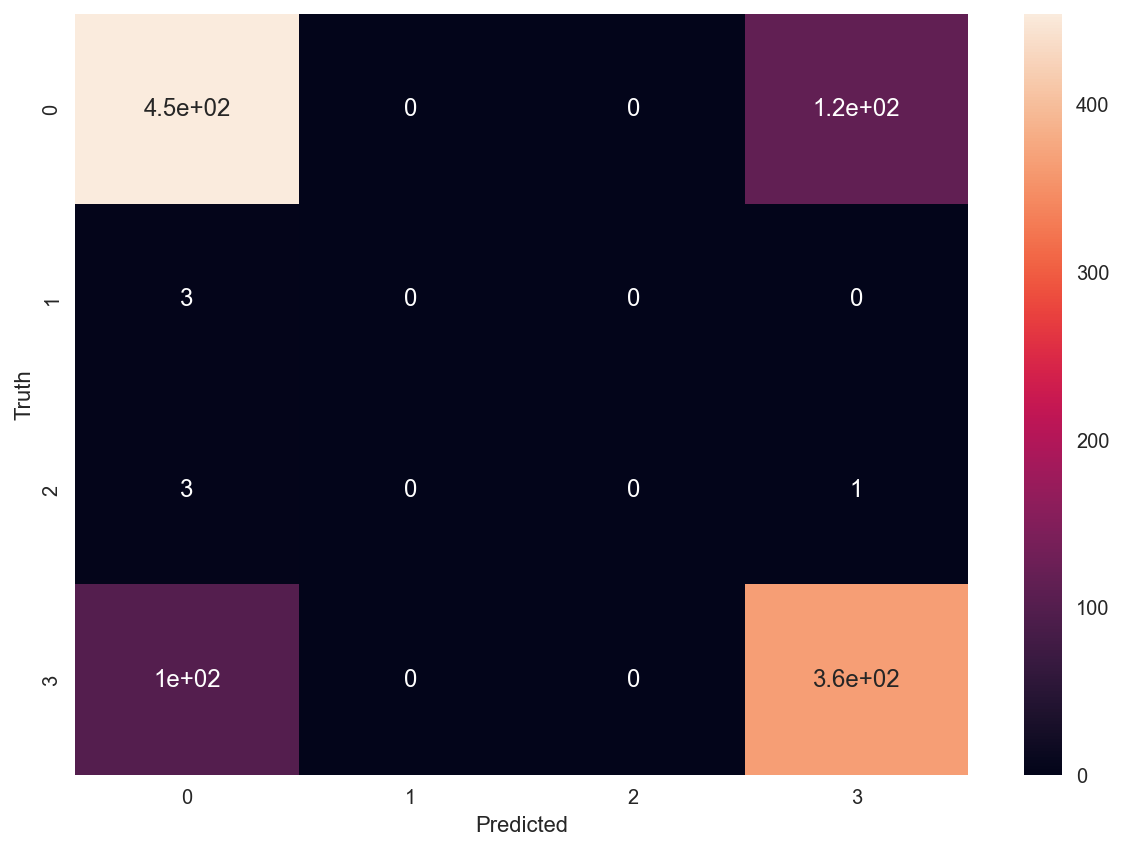

In [87]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [173]:
cnn = models.Sequential([
    add.Conv1D(filters=256, kernel_size=(3), activation='relu')
    add.MaxPooling1D((2)),
    
    #layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    add.Conv1D(filters=64, kernel_size=(3), activation='softmax'),
    add.MaxPooling1D((2)),
    
    
    layers.Flatten(),
    #layers.Dense(128, activation='mish','swish'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

SyntaxError: invalid syntax (3433940944.py, line 3)

In [174]:
X = df_no_outlier.drop('status', axis=1)   # axis=0 for row, axis=1 for column
y = df_no_outlier ['status']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (4166, 11)
y_train (4166,)
X_test (1042, 11)
y_test (1042,)


In [197]:
conv1d = Conv1D(input_shape=(11,1), kernel_size=2, filters=2)

model = Sequential()
model.add(conv1d)
model.add(Flatten())
model.add(Dense(16))


In [198]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [199]:
X_train = np.zeros((22,11,1))
y_train = np.zeros((22,11))
print(X_train.shape)

(22, 11, 1)


In [200]:
cnn.fit(X_train, y_train, epochs=40)

Epoch 1/40


ValueError: in user code:

    File "D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\DOWNLOADS\Anconda\envs\majorproject\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_22" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 11, 1)


In [201]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X,y)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: Dimension value must be integer or None or have an __index__ method, got value '       BQ   ESS        BMI  Weight  Height       Head  Neck  Waist  Buttock  \
0     0.0  14.0  29.065927    88.0   174.0  57.500000  39.0   95.5    106.5   
1     0.0   8.0  26.989619    78.0   170.0  57.000000  36.5   90.0    100.0   
2     0.0  16.0  23.939481    75.0   177.0  59.000000  39.0   88.0    104.0   
3     0.0  15.0  22.129740    67.0   174.0  57.000000  35.0   74.0     94.0   
4     0.0  15.0  22.129740    67.0   174.0  57.000000  35.0   74.0     94.0   
...   ...   ...        ...     ...     ...        ...   ...    ...      ...   
5240  1.0   6.0  24.005487    63.0   162.0  57.000000  33.0   99.0    101.5   
5241  0.0  13.0  29.964328    63.0   145.0  53.000000  35.8  102.0    112.0   
5242  0.0  13.0  29.964328    63.0   145.0  53.000000  35.8  102.0    112.0   
5243  0.0   0.0  24.654832    60.0   156.0  54.500000  35.0   83.5     99.0   
5244  1.0  17.0  20.077748    47.0   153.0  54.799999  30.5   68.0     88.0   

       Age  M  
0     20.0  1  
1     20.0  1  
2     20.0  1  
3     20.0  1  
4     20.0  1  
...    ... ..  
5240  77.0  0  
5241  77.0  0  
5242  77.0  0  
5243  79.0  0  
5244  80.0  0  

[5208 rows x 11 columns]' with type '<class 'pandas.core.frame.DataFrame'>'